**1.0: SETUP - Dependencies and Configuration**    
Import a selection of useful tools and define a few global config options.

In [1]:
import math, gc, re, pickle, datetime
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import column_or_1d

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_cal

**1.1: SETUP - Data Import**    
Load and combine datasets.

In [2]:
def get_dataset(prefix):
    with tqdm(total=3) as pbar:
        # The transaction .csv file has most of the information.
        df = pd.read_csv('../input/ieee-fraud-detection/'+ prefix + '_transaction.csv')
        pbar.update()

        # However, we also receive an identity set referenced by a 'TransactionID' column.
        df_id = pd.read_csv('../input/ieee-fraud-detection/'+ prefix + '_identity.csv')
        pbar.update()

        # So, let's merge those together.
        df = pd.merge(df, df_id, on='TransactionID', how='left')
        pbar.update()
    return df

# Training set
X = get_dataset('train')

# Testing set
P = get_dataset('test')

100%|██████████| 3/3 [00:32<00:00, 13.54s/it]


**1.2: SETUP - Data Compression**    
Reduce the memory footprint with type conversion.

In [3]:
def reduce_mem_usage(df):
    # We have a tight memory constraint on Kaggle.
    # This frees up some room to work.

    pre_mem = df.memory_usage().sum() / 1024**2 # Memory usage before type conversion.
    for col in tqdm(df.columns):
        if df[col].dtype != object: # Branch: Numeric
            c_min = df[col].min()
            c_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int': # Branch: Numeric: Integers
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else: # Branch: Numeric: Floats
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # Branch: Category
            df[col] = df[col].astype(np.object)

    end_mem = df.memory_usage().sum() / 1024**2 # Memory usage after type conversion.
    print('Memory usage: {:.2f} MB - Decreased by {:.1f}%'.format(end_mem, 100 * (pre_mem - end_mem) / pre_mem))

    return df

X = reduce_mem_usage(X)
y = X['isFraud']
P = reduce_mem_usage(P)
P_id = P['TransactionID']

  2%|▏         | 10/433 [00:00<00:05, 80.31it/s]

Memory usage: 650.48 MB - Decreased by 66.8%


100%|██████████| 433/433 [01:32<00:00,  4.68it/s]

Memory usage: 565.37 MB - Decreased by 66.3%


**2.0: EDA - Column groups**    
Exploring the grouped features of our dataset columns.

Total Features: **433**

* **ProductCD** (1)
* **addr_** (2)
* **dist_** (2)
* **Device_** (2)
* **\_emaildomain** (2)
* **Transaction_** (3)
* **card_** (6)
* **M_** (9)
* **C_** (14)
* **D_** (15)
* **id_** (38)
* **V_** (339)

In [4]:
# Feature table.

def list_columns(obj, cols=2, gap=2, width=40, columnwise=True):
    # Prints a list of items in columns.
    sobj = [str(item) for item in obj]
    if cols > len(sobj): cols = len(sobj)
    max_len = max([width] + [len(item) for item in sobj])
    if columnwise: cols = int(math.ceil(float(len(sobj)) / float(cols)))
    plist = [sobj[i: i+cols] for i in range(0, len(sobj), cols)]
    if columnwise:
        if not len(plist[-1]) == cols:
            plist[-1].extend(['']*(len(sobj) - len(plist[-1])))
        plist = zip(*plist)
    printer = '\n'.join([
        ''.join([c.ljust(max_len + gap) for c in p])
        for p in plist])
    print(printer)
    
def print_column(label, items):
    # Prints our column items with a FEATURE header.
    print('-' * 80)
    print('    FEATURE:', label, '({})'.format(len(items)))
    print('-' * 80)
    list_columns(items)
    
def nan_unique_col_stats(c, df_x, df_p):
    # Dataframe column stats
    # %E - Percent of rows in column that are empty.
    # %R - Percent of rows in column filled by a single repeating value.
    # %U - Percent of rows in column filled by unique non-repeating values.
    total_n_rows = len(df_x) + len(df_p)
    if df_x[c].dtype != object:
        if str(df_x[c].dtype)[:3] == 'int':
            c_type = 'i'
        else:
            c_type = 'f'
    else:
        c_type = 's'
    x_nan = df_x[c].isnull().sum()
    x_unique = df_x[c].nunique()
    x_rep = df_x[c].value_counts().tolist()[0]
    p_nan = df_p[c].isnull().sum()
    p_unique = df_p[c].nunique()
    p_rep = df_p[c].value_counts().tolist()[0]
    percent_nan = int((x_nan + p_nan) / total_n_rows * 100.0)
    percent_unique = int((x_unique + p_unique) / total_n_rows * 100.0)
    percent_rep = int((x_rep + p_rep) / total_n_rows * 100.0)
    return '{}[{}] ({}%E | {}%R | {}%U)'.format(c, c_type, percent_nan, percent_rep, percent_unique)

def display_feature_table(df, labels, features_grouped):
    print('-'*31 + 'TOTAL FEATURES:{}'.format(len(P.columns)) + '-'*31)
    for group in features_grouped:
        if len(features_grouped[group]) > 0:
            print_column(group, list(map(lambda x: nan_unique_col_stats(x, df, P), features_grouped[group])))

In [5]:
# Grouped Features

def make_feature_group(features, prefx_suffix, is_suffix=False, ex=[]):
    if is_suffix:
        featureGroup = [f for f in features if (f.endswith(prefx_suffix) and f not in ex)]
        featureGroup.sort()
        return featureGroup
    featureGroup = [f for f in features if (f.startswith(prefx_suffix) and f not in ex)]
    featureGroup.sort()
    return featureGroup

def get_feature_groups(features):
    features_grouped = {
        'addr': make_feature_group(features, 'addr'),
        'amt': make_feature_group(features, 'Amt_'),
        'c': make_feature_group(features, 'C'),
        'card': make_feature_group(features, 'card'),
        'd': make_feature_group(features, 'D', False, make_feature_group(features, 'Device') + make_feature_group(features, 'DT')),
        'device': make_feature_group(features, 'Device'),
        'dist': make_feature_group(features, 'dist'),
        'dt': make_feature_group(features, 'DT_'),
        'email': make_feature_group(features, 'email'),
        'id': make_feature_group(features, 'id_'),
        'm': make_feature_group(features, 'M'),
        'product': make_feature_group(features, 'Product'),
        'tx': make_feature_group(features, 'Transaction'),
        'v': make_feature_group(features, 'V')
    }
    return features_grouped

def remove_features(features, feature_removal_set):
    # Returns a sorted list with specified features removed.
    features_updated = list(set(features) - set(feature_removal_set))
    features_updated.sort()
    return features_updated

# Rename email columns for easy prefix grouping

X.rename(columns = {'P_emaildomain':'email_P'}, inplace = True) 
X.rename(columns = {'R_emaildomain':'email_R'}, inplace = True) 

P.rename(columns = {'P_emaildomain':'email_P'}, inplace = True) 
P.rename(columns = {'R_emaildomain':'email_R'}, inplace = True)

labels = ['isFraud']
features_engineered = []
features = list(set(X.columns) - set(labels))
features.sort()

features_grouped = get_feature_groups(features)
display_feature_table(X, labels, features_grouped)

-------------------------------TOTAL FEATURES:433-------------------------------
--------------------------------------------------------------------------------
    FEATURE: addr (2)
--------------------------------------------------------------------------------
addr1[f] (11%E | 7%R | 0%U)               addr2[f] (11%E | 87%R | 0%U)              
--------------------------------------------------------------------------------
    FEATURE: c (14)
--------------------------------------------------------------------------------
C1[f] (0%E | 53%R | 0%U)                  C3[f] (0%E | 98%R | 0%U)                  
C10[f] (0%E | 75%R | 0%U)                 C4[f] (0%E | 75%R | 0%U)                  
C11[f] (0%E | 66%R | 0%U)                 C5[f] (0%E | 64%R | 0%U)                  
C12[f] (0%E | 78%R | 0%U)                 C6[f] (0%E | 57%R | 0%U)                  
C13[f] (0%E | 33%R | 0%U)                 C7[f] (0%E | 87%R | 0%U)                  
C14[f] (0%E | 54%R | 0%U)                 C

**2.1: EDA - Missing Features**    
**V107** has a single unique value for one of our datasets. We can probably let this one go.

These columns are more than 90% empty:
* **D7**
* **dist2**
* **id_07**
* **id_08**
* **id_18**
* **id_21**
* **id_22**
* **id_23**
* **id_24**
* **id_25**
* **id_26**
* **id_27**

In [6]:
def get_one_val_cols(df_list):
    total_one_val_cols = []
    for df in df_list:
        one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
        total_one_val_cols += one_value_cols
    total_one_val_cols = list(set(total_one_val_cols))
    total_one_val_cols.sort()
    return total_one_val_cols

def get_nan_val_cols(df_list, thresh):
    total_nan_val_cols = []
    for df in df_list:
        nan_value_cols = [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > thresh]
        total_nan_val_cols += nan_value_cols
    total_nan_val_cols = list(set(total_nan_val_cols))
    total_nan_val_cols.sort()
    return total_nan_val_cols

one_val_cols = get_one_val_cols([X, P])
nan_val_cols = get_nan_val_cols([X, P], 0.9)
print('One value columns:', one_val_cols)
print('>90% NaN value columns:', nan_val_cols)

One value columns: ['V107']
>90% NaN value columns: ['D7', 'dist2', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [7]:
features = remove_features(features, ['V107', 'D7', 'dist2', 'id_07', 'id_08', 'id_18', 'id_21',
                                      'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27'])
features_grouped = get_feature_groups(features)

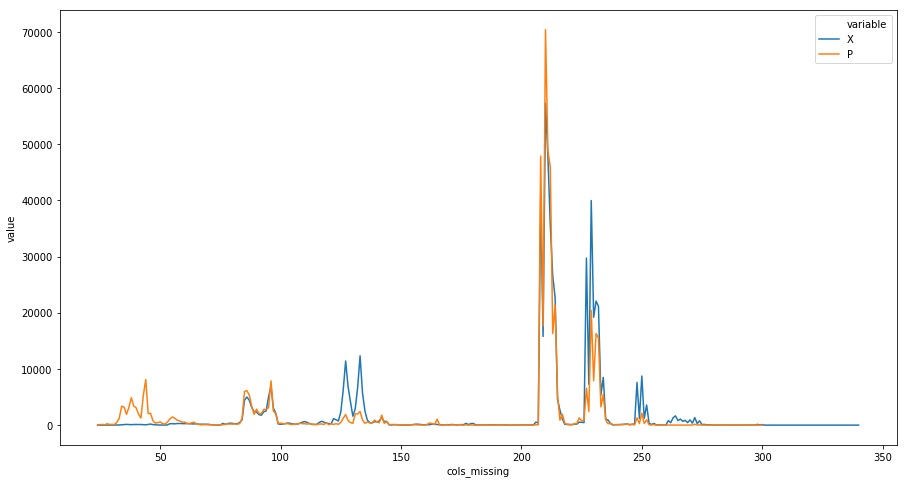

In [8]:
def plot_missing_cols(X, P):
    missing_cols_X = X.isnull().sum(axis=1).value_counts().to_frame()
    missing_cols_X.reset_index(inplace=True)
    missing_cols_X.columns = ['cols_missing', 'X']
    
    missing_cols_P = P.isnull().sum(axis=1).value_counts().to_frame()
    missing_cols_P.reset_index(inplace=True)
    missing_cols_P.columns = ['cols_missing', 'P']
    
    missing_cols = pd.merge(missing_cols_X, missing_cols_P, on='cols_missing', how='left')
    plt.figure(figsize=(15,8))
    sns.lineplot(x='cols_missing', y='value', hue='variable', data=pd.melt(missing_cols, ['cols_missing']))

def plot_bar_col_norm_values(df_x, df_p, col, val_range=None):
    plt.figure(figsize=(15,8))
    vals_x = df_x[col].value_counts(normalize=True).map(lambda x: x * 100.0)
    vals_x = vals_x.to_frame()
    vals_x.reset_index(inplace=True)
    vals_x.columns = [col, 'X']
    
    vals_p = df_p[col].value_counts(normalize=True).map(lambda x: x * 100.0)
    vals_p = vals_p.to_frame()
    vals_p.reset_index(inplace=True)
    vals_p.columns = [col, 'P']
    
    vals = pd.merge(vals_x, vals_p, on=col, how='left')
    if val_range != None:
        vals = vals.iloc[0:val_range]
    sns.barplot(x=col, y='value', hue='variable', data=pd.melt(vals, [col]))
    
def plot_fraud_correlation(df, col):
    fraud_count = df[df['isFraud']==1][col].value_counts(normalize=True).map(lambda x: x * 100).to_frame().reset_index()
    fraud_count.columns = ['category', 'fraud_freq']
    valid_count = df[df['isFraud']==0][col].value_counts(normalize=True).map(lambda x: x * 100).to_frame().reset_index()
    valid_count.columns = ['category', 'valid_freq']
    cardType = pd.merge(fraud_count, valid_count, on='category')
    cardType['difference'] = cardType['fraud_freq'] - cardType['valid_freq']
    
    pal = sns.color_palette('coolwarm', len(cardType))
    rank = cardType['difference'].values.argsort().argsort()
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x="category", y="difference", data=cardType, ax=ax, palette=np.array(pal)[rank])
    ax.title.set_text('Fraud-correlation: {}'.format(col))
    
def plot_fraud_bin(df, c, bins=12):
    bins_df = df[[c, 'isFraud']][c].value_counts(bins=bins).to_frame()
    for i in bins_df.index:
        fraud_count = df[(df[c] > i.left) & (df[c] <= i.right)]['isFraud'].sum()
        bins_df.loc[i, c] = round((i.left + i.right) / 2 * 100) / 100
        bins_df.loc[i, 'isFraud'] = fraud_count
    fraud_total = bins_df['isFraud'].sum()
    for i in bins_df.index:
        fraud_perc = bins_df.loc[i, 'isFraud'] / fraud_total * 100.0
        bins_df.loc[i, 'percent_fraud'] = fraud_perc
    bins_df = bins_df.sort_values(by=[c])
    bins_df.reset_index(inplace=True)
    bins_df = bins_df.drop('index', 1)

    fraud_bins = bins_df[[c, 'percent_fraud']]
    pal = sns.color_palette('coolwarm', len(fraud_bins))
    rank = fraud_bins['percent_fraud'].values.argsort().argsort()

    plt.figure(figsize=(15,8))
    sns.barplot(x=c, y='percent_fraud', palette=np.array(pal)[rank], data=fraud_bins, ci=None)
    
def plot_violin(df, cols, labels):
    violin = df[cols]
    violin.columns = labels
    fig, ax = plt.subplots()
    sns.violinplot(x=labels[0], y=labels[1], split=True, inner="quart", data=violin, ax=ax)

plot_missing_cols(X, P)

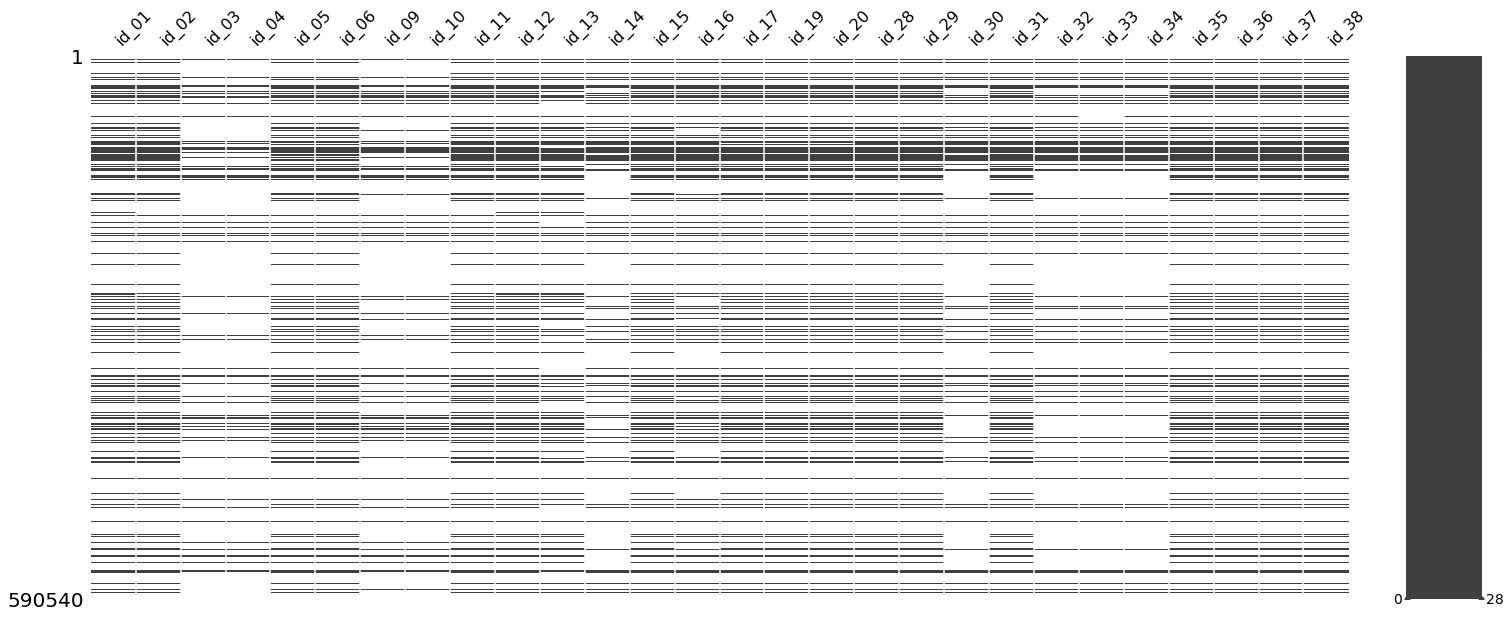

In [9]:
msno.matrix(X[features_grouped['id']])

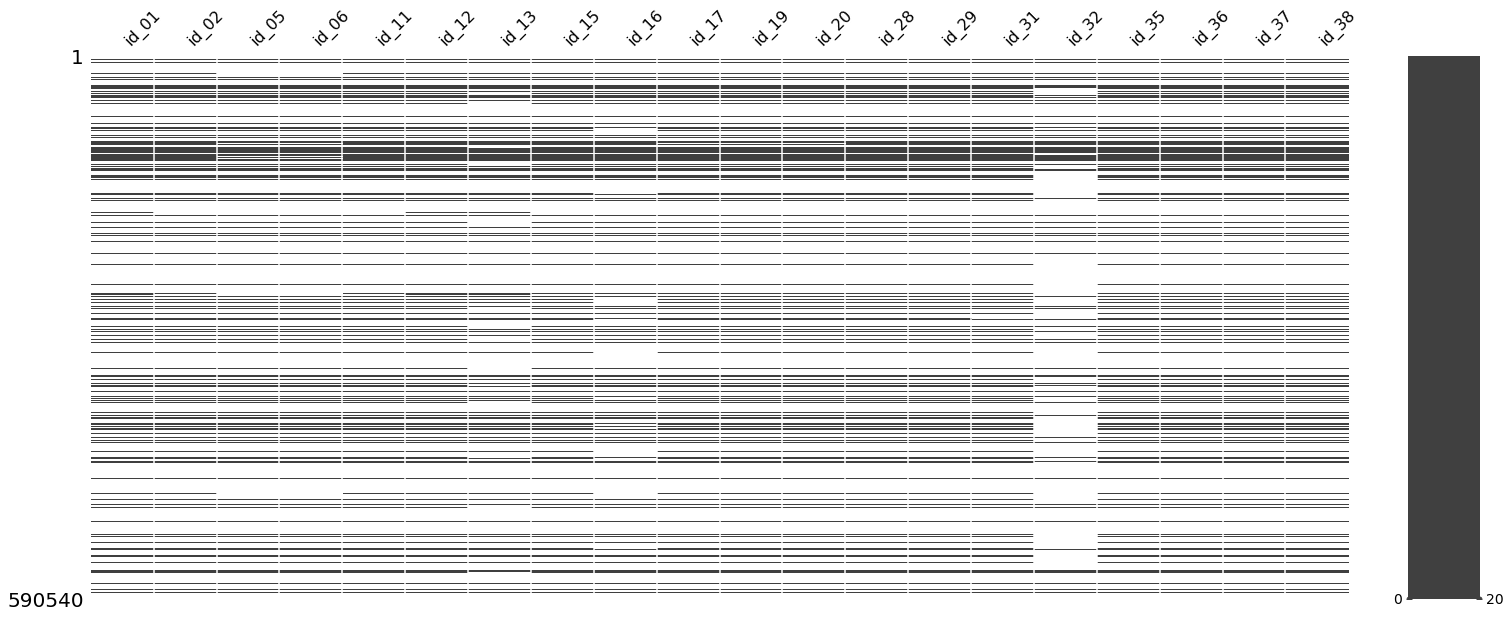

In [10]:
features = remove_features(features, ['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14',
                                      'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
                                      'id_27', 'id_30', 'id_33', 'id_34'])
features_grouped = get_feature_groups(features)
msno.matrix(X[features_grouped['id']])

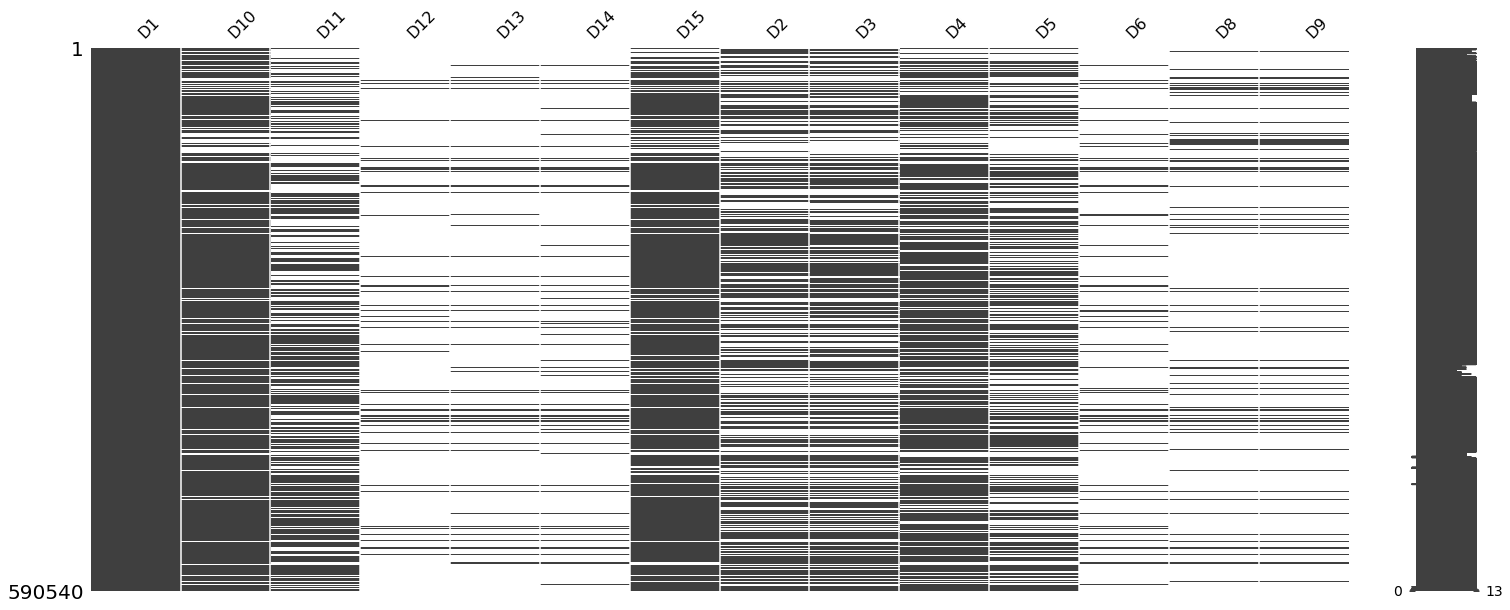

In [11]:
msno.matrix(X[features_grouped['d']])

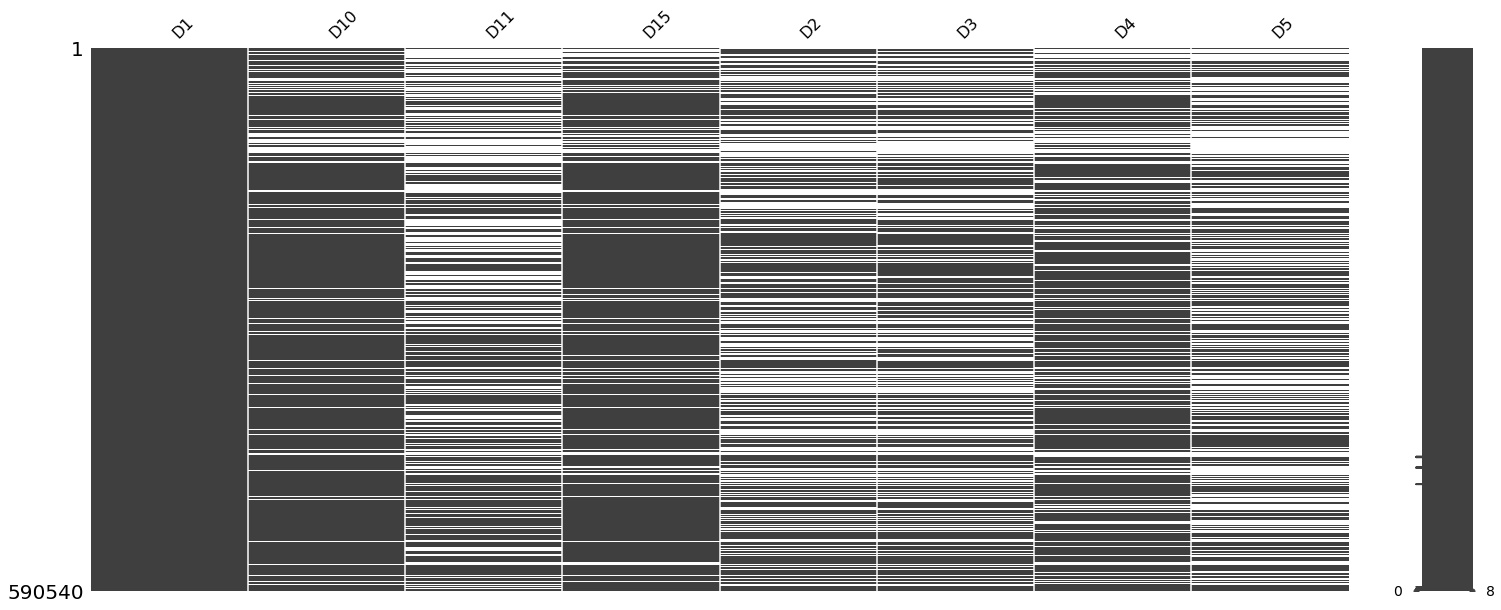

In [12]:
features = remove_features(features, ['D12', 'D13', 'D14', 'D6', 'D8', 'D9'])
features_grouped = get_feature_groups(features)
msno.matrix(X[features_grouped['d']])

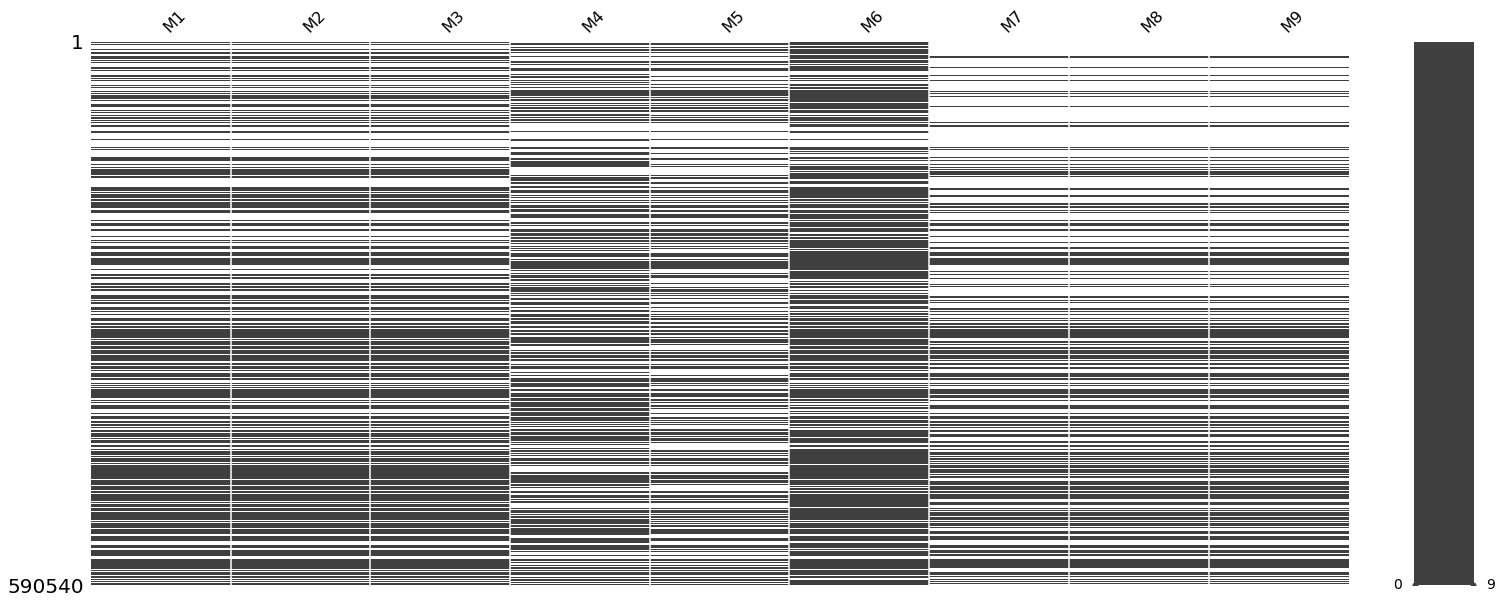

In [13]:
msno.matrix(X[features_grouped['m']])

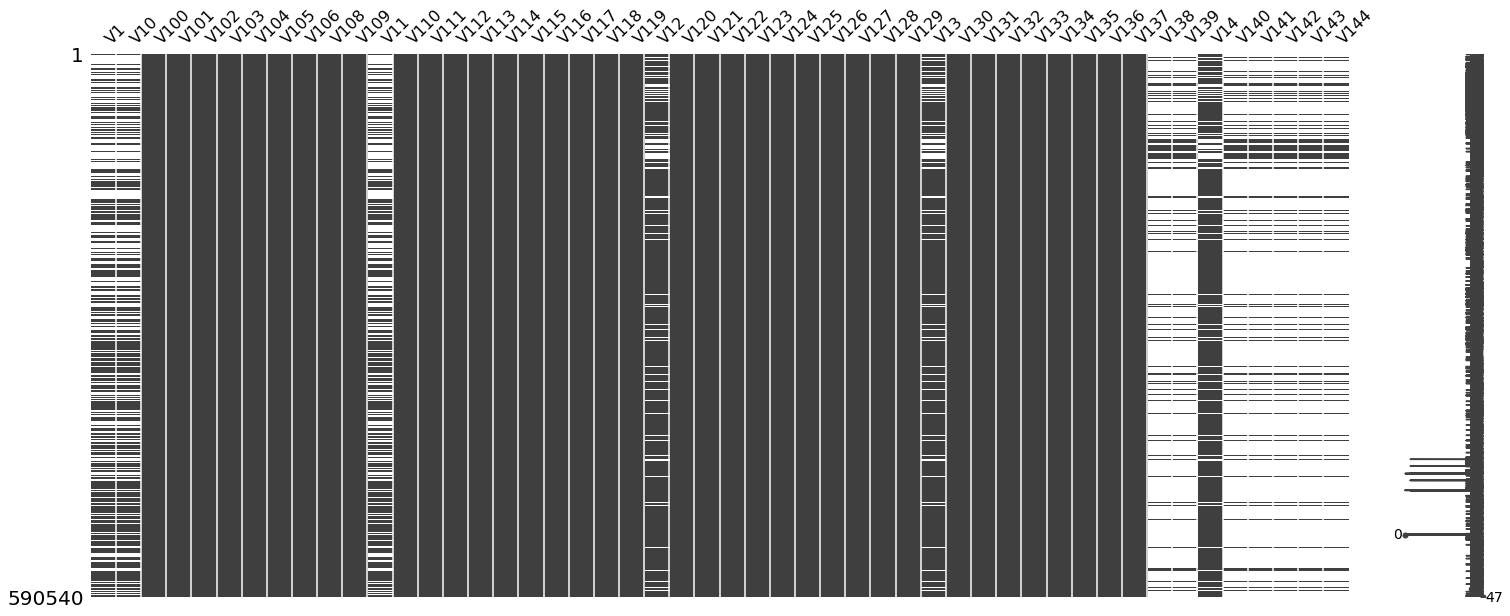

In [14]:
msno.matrix(X[features_grouped['v'][0:50]])

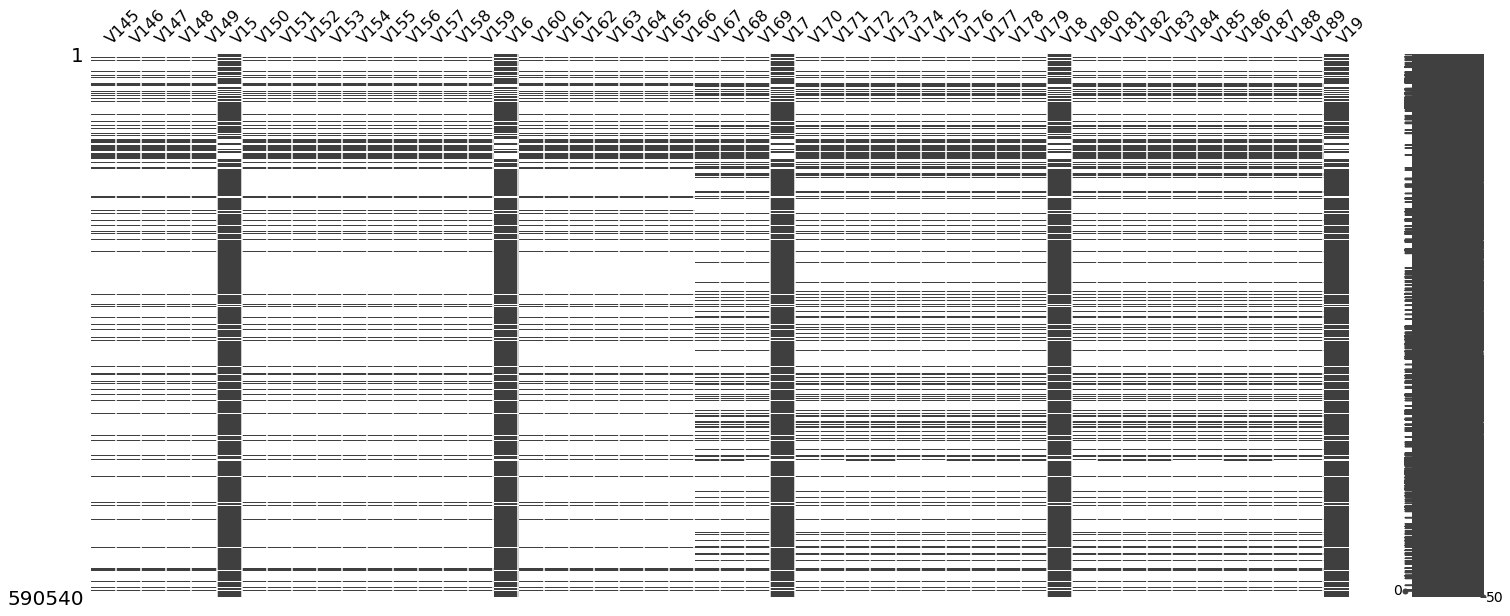

In [15]:
msno.matrix(X[features_grouped['v'][50:100]])

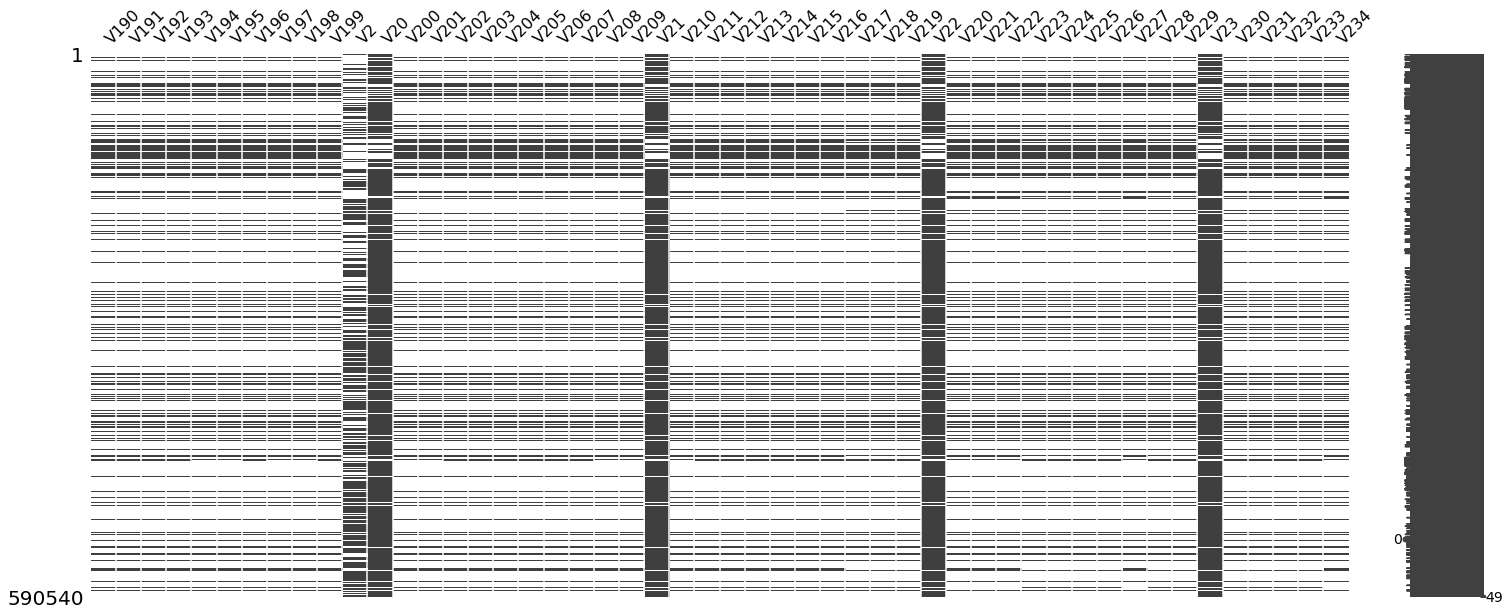

In [16]:
msno.matrix(X[features_grouped['v'][100:150]])

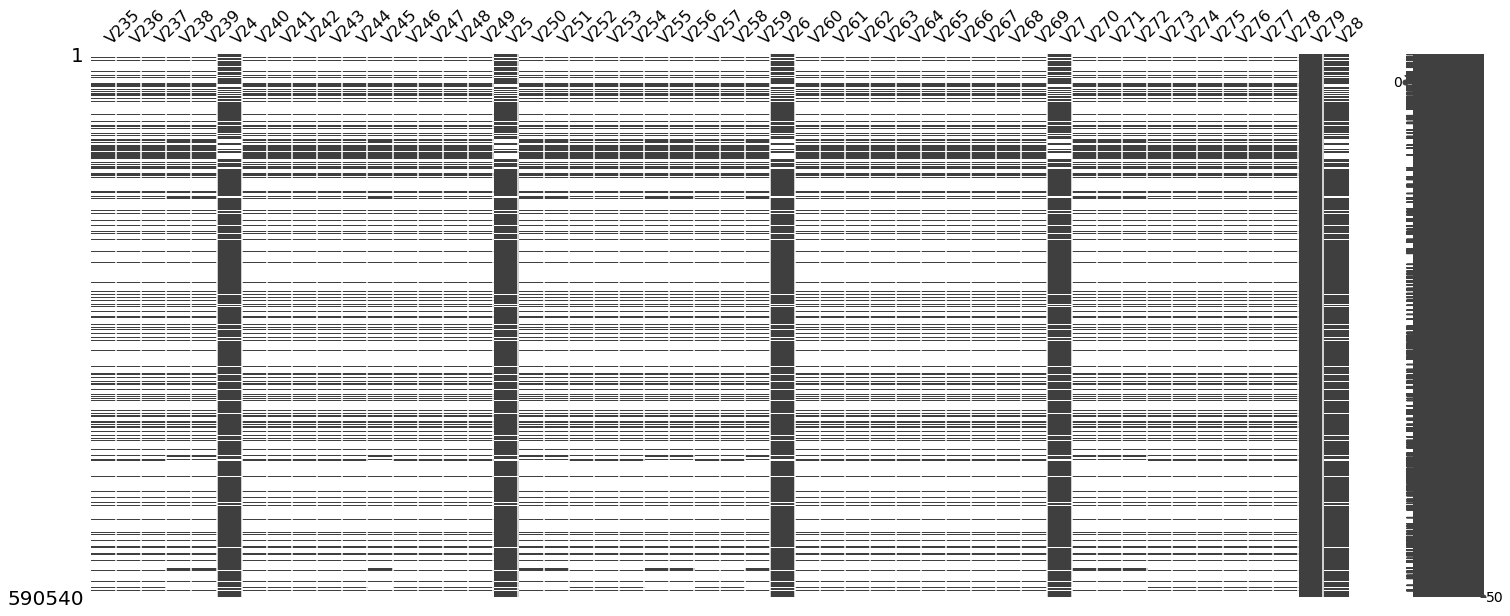

In [17]:
msno.matrix(X[features_grouped['v'][150:200]])

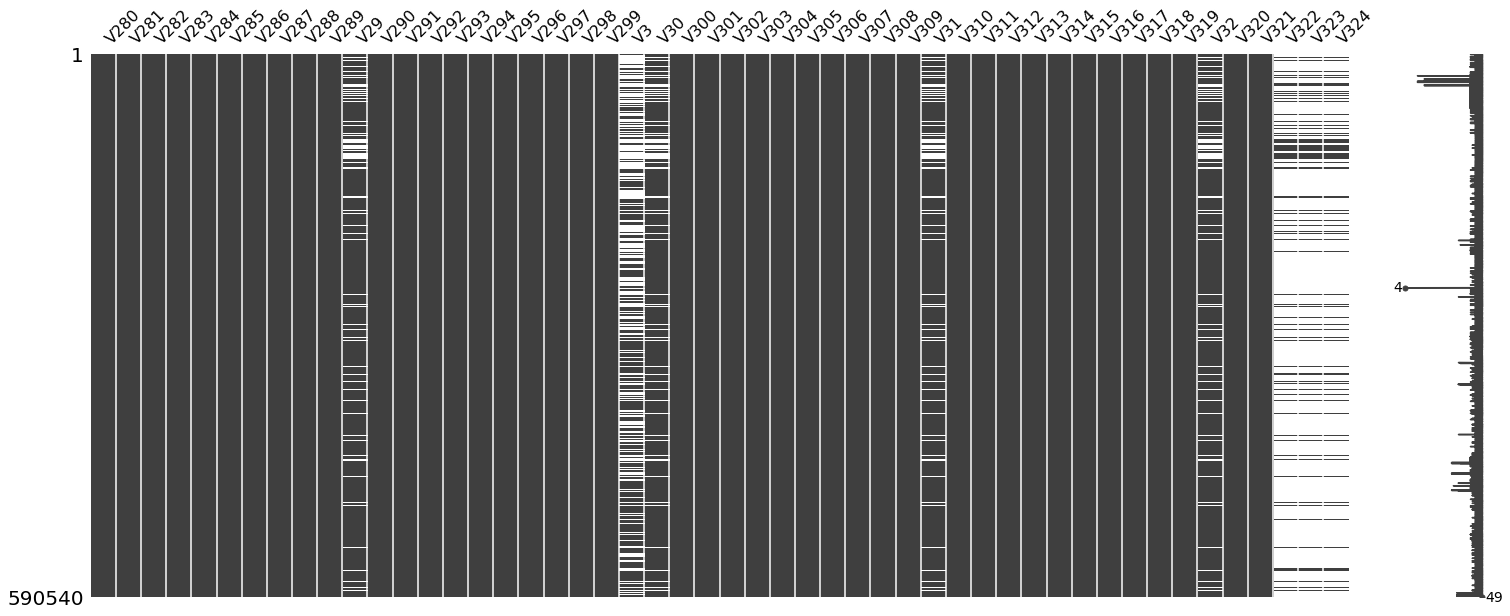

In [18]:
msno.matrix(X[features_grouped['v'][200:250]])

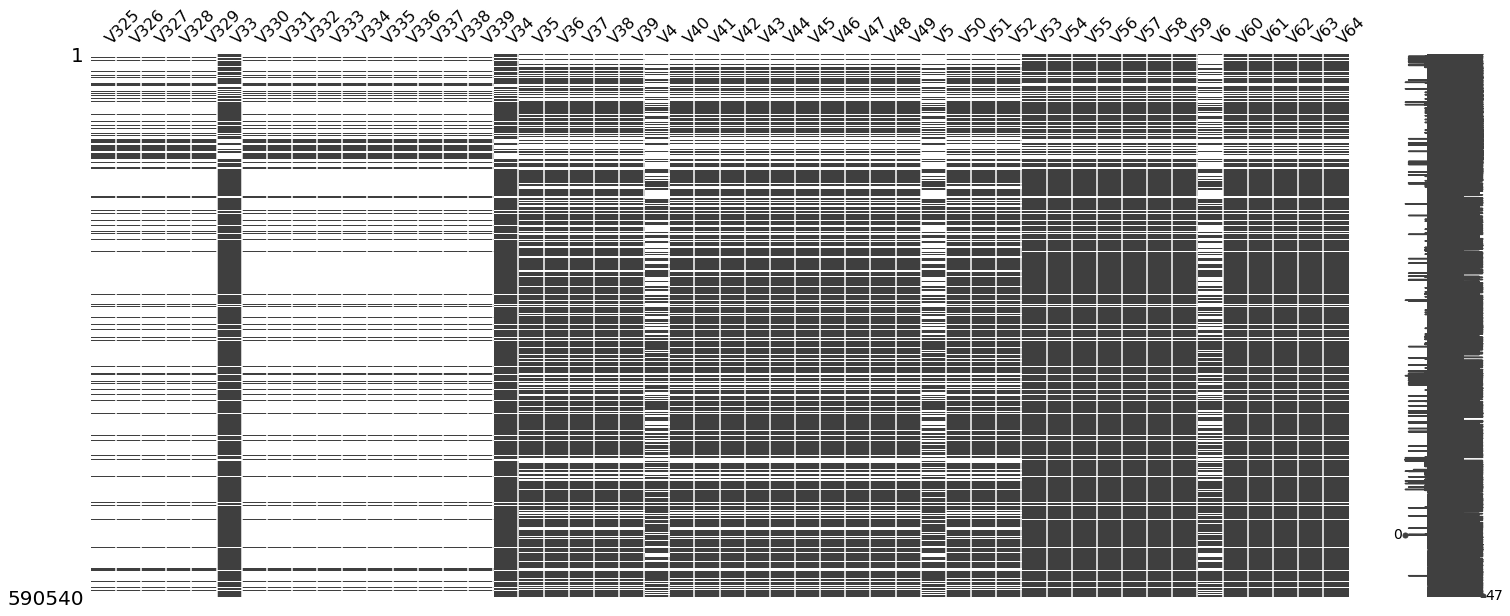

In [19]:
msno.matrix(X[features_grouped['v'][250:300]])

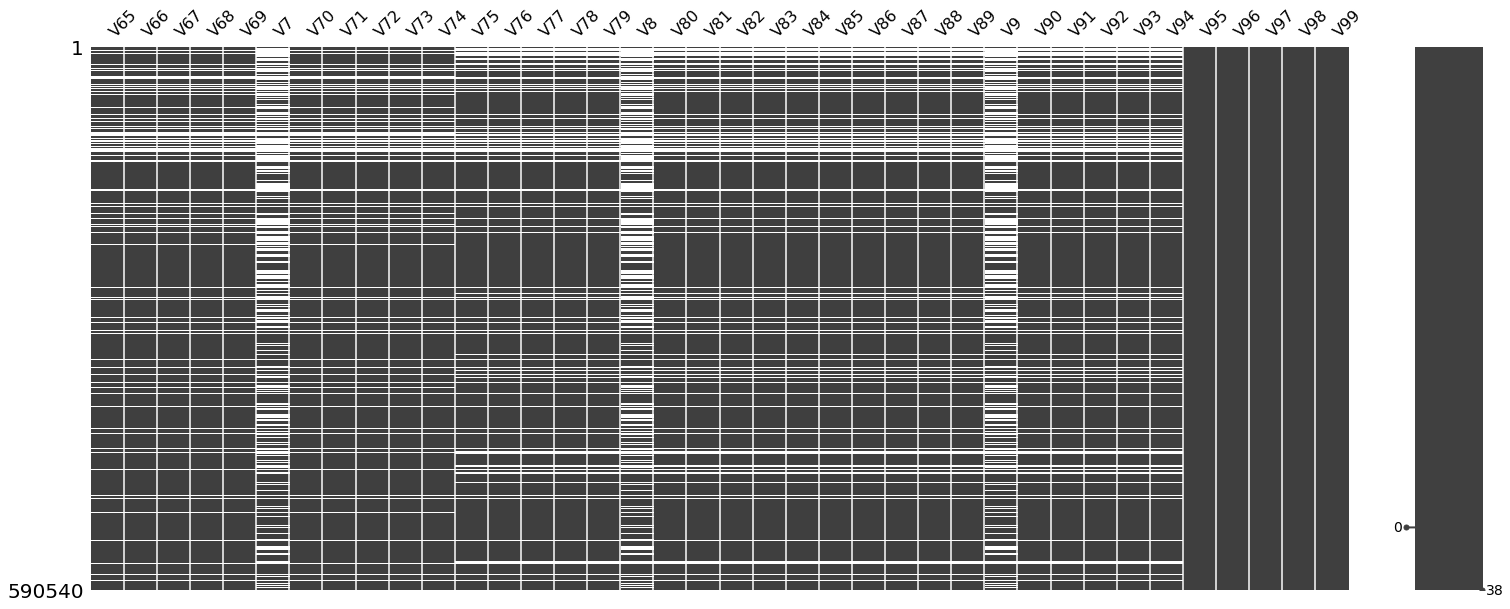

In [20]:
msno.matrix(X[features_grouped['v'][300:350]])

In [21]:
print('Columns remaining:', len(features))

Columns remaining: 406


In [22]:
features = remove_features(features, ['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144',
                                      'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151',
                                      'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158',
                                      'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165',
                                      'V166', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
                                      'V331', 'V332' ,'V333', 'V334', 'V335', 'V336', 'V337',
                                      'V338', 'V339'])
features_grouped = get_feature_groups(features)

**2.2: EDA - Address Features**    
We have **2** address features (addr1, addr2) stored as *floats*.

* **~11%** of the dataset is missing from each column.
* **addr1** has a low number of single unique values / single repetitions.
* **addr2** has a high number of single value repetitions.

It looks like **addr1** would be a great feature to use for training and feature engineering.

In [23]:
X['addr1'].value_counts(dropna=True).to_frame().head(5)

,addr1
299.0,46335
325.0,42751
204.0,42020
264.0,39870
330.0,26287


In [24]:
X['addr2'].value_counts(dropna=True).to_frame().head(5)

,addr2
87.0,520481
60.0,3084
96.0,638
32.0,91
65.0,82


Many of our values are stored as *floats* (due to NaNs) when the data is comprised of *integers*.

In [25]:
def decimal_sep(f):
    return math.modf(f)[0]

def int_sep(f):
    return int(math.modf(f)[1])

def unused_zero(df):
    if len(df[df.T == 0]) > 0:
        return False
    return True

def unused_negative(df):
    if len(df[df < 0]) > 0:
        return False
    return True

def unused_positive(df):
    if len(df[df > 0]) >= 0:
        return False
    return True

def is_int(df):
    df_d = df.dropna().apply(decimal_sep)
    if df_d.value_counts().index.tolist()[0] == 0:
        return True
    return False

def is_divisible(df, n, ignore_nan=False):
    total = len(df)
    if ignore_nan:
        total -= df.isna().sum()
    if df[df % n == 0].count() == total:
        return True
    return False

def fix_floats_col(df, col):
    c_min = df[col].min()
    c_max = df[col].max()
    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
        df[col] = df[col].astype(np.int8)
    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
        df[col] = df[col].astype(np.int16)
    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
        df[col] = df[col].astype(np.int32)
    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
        df[col] = df[col].astype(np.int64)  

def fix_floats(df):
    fixed_floats = []
    for col in tqdm(df.columns):
        if str(df[col].dtype)[:5] == 'float' and is_int(df[col]):
            fixed_floats.append(col)
            fix_floats_col(df, col)
    print('Converted the following floats to integers:', fixed_floats)    

def check_types(df_list, col):
    print(col, 'min-range:', list(map(lambda x: x[col].min(), df_list)))
    print(col, 'max-range:', list(map(lambda x: x[col].max(), df_list)))
    print(col, 'unused negative space:', list(map(lambda x: unused_negative(x[col]), df_list)))
    print(col, 'unused positive space:', list(map(lambda x: unused_positive(x[col]), df_list)))
    print(col, 'unused zeros:', list(map(lambda x: unused_zero(x[col]), df_list)))
    print(col, 'is integer:', list(map(lambda x: is_int(x[col]), df_list)))

**addr1** and **addr2** are indeed just positive integers.

In [26]:
check_types([X, P], 'addr1')

addr1 min-range: [100.0, 100.0]
addr1 max-range: [540.0, 540.0]
addr1 unused negative space: [True, True]
addr1 unused positive space: [False, False]
addr1 unused zeros: [True, True]
addr1 is integer: [True, True]


In [27]:
check_types([X, P], 'addr2')

addr2 min-range: [10.0, 10.0]
addr2 max-range: [102.0, 102.0]
addr2 unused negative space: [True, True]
addr2 unused positive space: [False, False]
addr2 unused zeros: [True, True]
addr2 is integer: [True, True]


Since 0 isn't used, we'll fill the NaN's with zeros and convert to *ints*.

In [28]:
cols_to_fill_zero_and_make_int = ['addr1', 'addr2']
for c in cols_to_fill_zero_and_make_int:
    X[c].fillna(0.0, inplace=True)
    P[c].fillna(0.0, inplace=True)
    fix_floats_col(X, c)
    fix_floats_col(P, c)

In [29]:
X['addr1'].head(5)

0    315
1    325
2    330
3    476
4    420
Name: addr1, dtype: int16

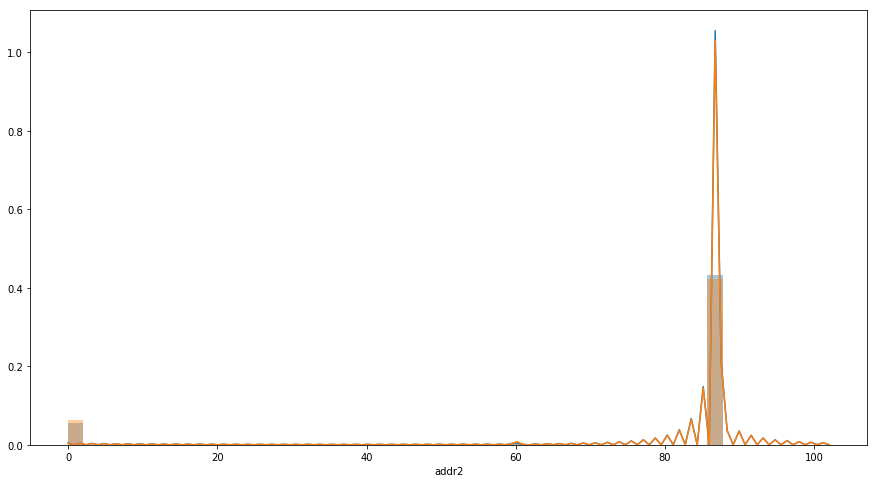

In [30]:
plt.figure(figsize=(15,8))
sns.distplot(X['addr2'])
sns.distplot(P['addr2'])

**addr2** doesn't seem to have much data outside the 80-100 range.

In [31]:
features = remove_features(features, ['addr2'])
features_grouped = get_feature_groups(features)

The fraudulent transactions have a slight bump in the middle of the **addr1** value range.

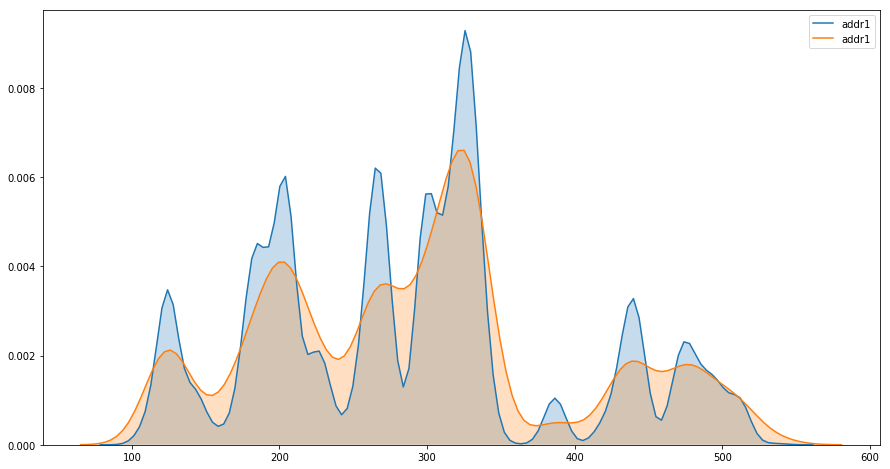

In [32]:
plt.figure(figsize=(15,8))
sns.kdeplot(X[(X['isFraud'] == 0) & (X['addr1'] > 0)]['addr1'], shade=True)
sns.kdeplot(X[(X['isFraud'] == 1) & (X['addr1'] > 0)]['addr1'], shade=True)

**2.3: EDA - Card Features**    
We have **6** card features (**card1, card2, card3, card4, card5, card6**) stored as *mixed* types.

* Across the **card** features, there is very little missing data.
* **card1** is an *integer* type with a low unique / repetition count. The data appears to be a list of encoded index numbers.
* **card2** has a low unique count and a moderately-low repetition count.
* **card3-card6** are very high in repetitions.
* **card4 & card6** are *string* types.
* There are 4 categories of **card4** values (**visa, mastercard, discover, american express**)
* There are 4 categories of **card6** values (**debit, credit, debit or credit, charge card**) In the test set (P), the **debit or credit** and **charge card** categories are largely absent.

It looks like **card1, card2, card4, & card6** will be useful.

In [33]:
X['card1'].value_counts(dropna=True).to_frame().head(5)

,card1
7919,14932
9500,14162
15885,10361
17188,10344
15066,7945


In [34]:
X['card2'].value_counts(dropna=True).to_frame().head(5)

,card2
321.0,48935
111.0,45191
555.0,41995
490.0,38145
583.0,21803


In [35]:
check_types([X, P], 'card2')

X['card2'].fillna(0, inplace=True)
P['card2'].fillna(0, inplace=True)
fix_floats_col(X, c)
fix_floats_col(P, c)

card2 min-range: [100.0, 100.0]
card2 max-range: [600.0, 600.0]
card2 unused negative space: [True, True]
card2 unused positive space: [False, False]
card2 unused zeros: [True, True]
card2 is integer: [True, True]


In [36]:
check_types([X, P], 'card3')

X['card3'].fillna(0, inplace=True)
P['card3'].fillna(0, inplace=True)
fix_floats_col(X, c)
fix_floats_col(P, c)

card3 min-range: [100.0, 100.0]
card3 max-range: [231.0, 232.0]
card3 unused negative space: [True, True]
card3 unused positive space: [False, False]
card3 unused zeros: [True, True]
card3 is integer: [True, True]


**X: card4**

In [37]:
X['card4'].value_counts(dropna=True).to_frame()

,card4
visa,384767
mastercard,189217
american express,8328
discover,6651


**P: card4**

In [38]:
P['card4'].value_counts(dropna=True).to_frame()

,card4
visa,334882
mastercard,158169
american express,7681
discover,2873


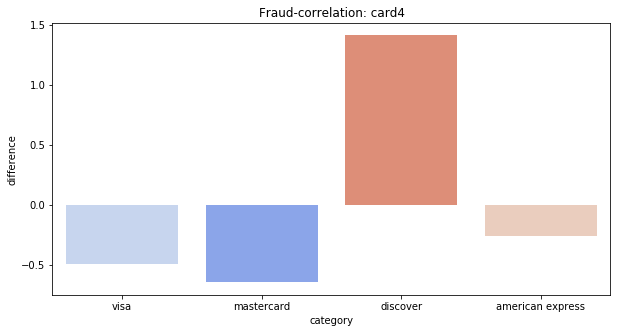

In [39]:
plot_fraud_correlation(X, 'card4')

In [40]:
check_types([X, P], 'card5')

X['card5'].fillna(0, inplace=True)
P['card5'].fillna(0, inplace=True)
fix_floats_col(X, c)
fix_floats_col(P, c)

card5 min-range: [100.0, 100.0]
card5 max-range: [237.0, 237.0]
card5 unused negative space: [True, True]
card5 unused positive space: [False, False]
card5 unused zeros: [True, True]
card5 is integer: [True, True]


**X: card6**

In [41]:
X['card6'].value_counts(dropna=True).to_frame()

,card6
debit,439938
credit,148986
debit or credit,30
charge card,15


**P: card6**

In [42]:
P['card6'].value_counts(dropna=True).to_frame()

,card6
debit,385021
credit,118662
charge card,1


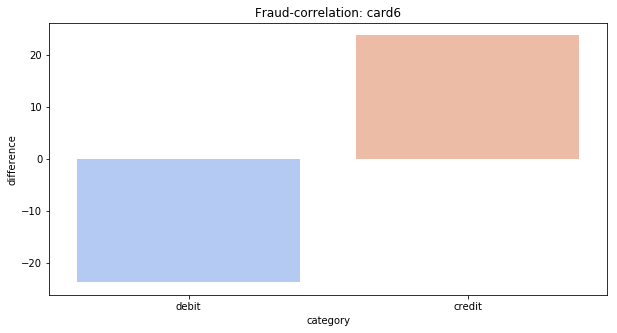

In [43]:
plot_fraud_correlation(X, 'card6')

Let's number **card4** and **card6**.

In [44]:
card4_LUT = {
    'visa': 1,
    'mastercard': 2,
    'american express': 3,
    'discover': 4
}

card6_LUT = {
    'debit': 1,
    'credit': 2,
    'debit or credit': 3,
    'charge card': 4
}

X['card4'] = X['card4'].map(lambda x: 0 if x not in card4_LUT else card4_LUT[x])
P['card4'] = P['card4'].map(lambda x: 0 if x not in card4_LUT else card4_LUT[x])

X['card6'] = X['card6'].map(lambda x: 0 if x not in card6_LUT else card6_LUT[x])
P['card6'] = P['card6'].map(lambda x: 0 if x not in card6_LUT else card6_LUT[x])

X['card4'] = X['card4'].astype(np.int8)
X['card6'] = X['card6'].astype(np.int8)
P['card4'] = P['card4'].astype(np.int8)
P['card6'] = P['card6'].astype(np.int8)

**2.4: EDA - Distance Features**    
We have **2** dist features (**dist1**, **dist2**) stored as *float* types.

* *Most* of the data is missing from **dist2**.
* Half of the data is missing from **dist1**.

In [45]:
X['dist1_log'] = X['dist1'].map(lambda x: 0 if x <= 0 else np.log(x))
P['dist1_log'] = P['dist1'].map(lambda x: 0 if x <= 0 else np.log(x))

features = remove_features(features, ['dist1', 'dist2'])
features_grouped = get_feature_groups(features)

features_engineered = features_engineered + ['dist1_log']

In [46]:
X['dist1'].value_counts().to_frame().head(5)

,dist1
0.0,19824
1.0,18330
2.0,17028
4.0,13067
3.0,12808


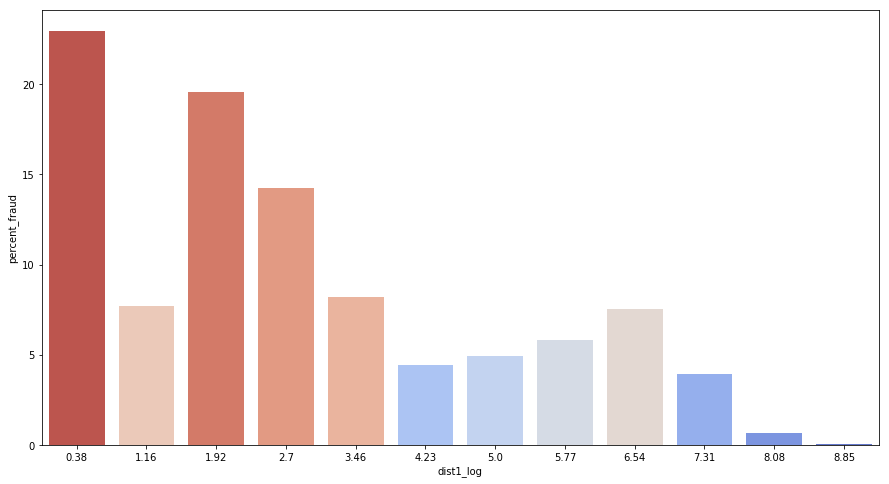

In [47]:
plot_fraud_bin(X, 'dist1_log')

**2.5: EDA - Email Features**    
We have **2** email features (**email_P**, **email_R**) stored as *string* types.

* **email_P** has ~40% repetition from a single domain.
* **email_R** is missing ~75% of the data.

**X: email_P**

In [48]:
X['email_P'].value_counts(dropna=True).to_frame().head(5)

,email_P
gmail.com,228355
yahoo.com,100934
hotmail.com,45250
anonymous.com,36998
aol.com,28289


**P: email_P**

In [49]:
P['email_P'].value_counts(dropna=True).to_frame().head(5)

,email_P
gmail.com,207448
yahoo.com,81850
hotmail.com,40399
anonymous.com,34064
aol.com,24048


Let's split up and bucket the email domain features.

In [50]:
def dot_count(s):
    # Count the number of dots in a string
    if not s or not isinstance(s, str):
        return 0

    return s.count('.')

def email_bucket_first(s):
    if not s or not isinstance(s, str):
        return 'none'

    buckets = {
        '': 'none',
        'juno': 'other',
        'sc': 'school',
        'aim': 'aol',
        'aol': 'aol',
        'bellsouth': 'provider',
        'suddenlink': 'provider',
        'icloud': 'apple',
        'ptd': 'other',
        'att': 'provider',
        'outlook': 'microsoft',
        'gmail': 'google',
        'rocketmail': 'yahoo',
        'charter': 'provider',
        'twc': 'provider',
        'prodigy': 'provider',
        'cox': 'provider',
        'msn': 'microsoft',
        'verizon': 'provider',
        'gmx': 'other',
        'windstream': 'other',
        'frontier': 'provider',
        'embarqmail': 'provider',
        'mail': 'other',
        'cableone': 'provider',
        'web': 'other',
        'servicios-ta': 'spanish',
        'mac': 'apple',
        'scranton': 'school',
        'q': 'provider',
        'anonymous': 'other',
        'roadrunner': 'provider',
        'optonline': 'provider',
        'live': 'microsoft',
        'earthlink': 'provider',
        'yahoo': 'yahoo',
        'protonmail': 'other',
        'sbcglobal': 'provider',
        'centurylink': 'provider',
        'cfl': 'provider',
        'netzero': 'provider',
        'ymail': 'yahoo',
        'frontiernet': 'provider',
        'hotmail': 'microsoft',
        'me': 'apple',
        'comcast': 'provider'
    }
    
    return buckets.get(s, 'other')

def email_bucket_last(s):
    if not s or not isinstance(s, str):
        return 'none'

    buckets = {
        '': 'none',
        'com': 'us',
        'net': 'us',
        'mx': 'mexico',
        'es': 'spain',
        'de': 'germany',
        'fr': 'france',
        'uk': 'uk',
        'jp': 'japan'
    }
    
    return buckets.get(s, 'other')

def add_email_buckets(df):
    domainCols_first = ['email_P_first', 'email_R_first']
    domainCols_last = ['email_P_last', 'email_R_last']

    for col in domainCols_first:
        df[col + '_bucket'] = df[col].map(email_bucket_first)
        
    for col in domainCols_last:
        df[col + '_bucket'] = df[col].map(email_bucket_last)

def first_domain_lowered(s):
    # Just the first domain (lowercase)
    if not s or not isinstance(s, str):
        return ''
    
    domain_list = s.split('.')

    return domain_list[0].lower()
    
def last_tld_lowered(s):
    # Just the last top-level domain (lowercase)
    if not s or not isinstance(s, str):
        return ''
    
    domain_list = s.split('.')

    return domain_list[-1].lower()

def add_email_first_part(df):
    domainCols = ['email_P', 'email_R']
    for col in domainCols:
        df[col + '_first'] = df[col].map(first_domain_lowered)
        
def add_email_last_part(df):
    domainCols = ['email_P', 'email_R']
    for col in domainCols:
        df[col + '_last'] = df[col].map(last_tld_lowered)
    
def add_email_dots(df):
    # Add dot count to dataframe

    domainCols = ['email_P', 'email_R']
    for col in domainCols:
        df[col + '_dots'] = df[col].map(dot_count)
        
add_email_dots(X)
add_email_first_part(X)
add_email_last_part(X)
add_email_buckets(X)

add_email_dots(P)
add_email_first_part(P)
add_email_last_part(P)
add_email_buckets(P)

features = remove_features(features, ['email_P', 'email_R'])
features_grouped = get_feature_groups(features)

features_engineered = features_engineered + ['email_P_dots', 'email_R_dots', 'email_P_first',
                                             'email_P_last', 'email_R_first', 'email_R_last',
                                             'email_P_first_bucket', 'email_R_first_bucket',
                                             'email_P_last_bucket', 'email_R_last_bucket']

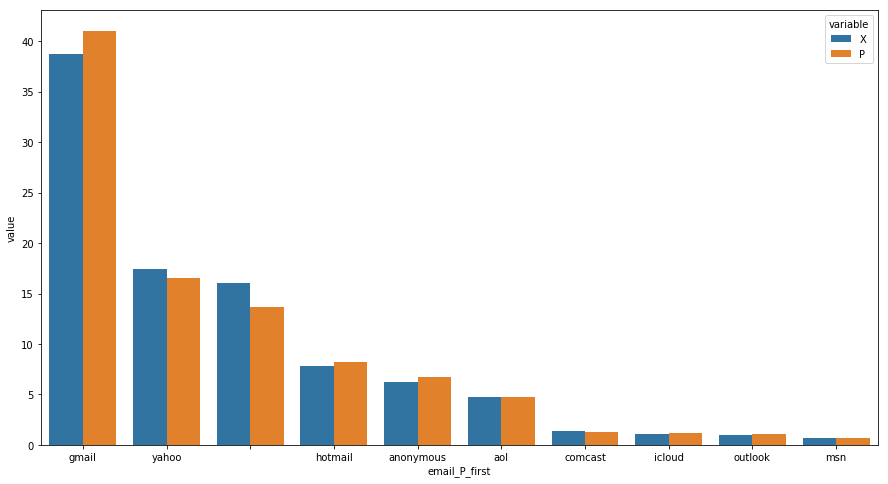

In [51]:
plot_bar_col_norm_values(X, P, 'email_P_first', 10)

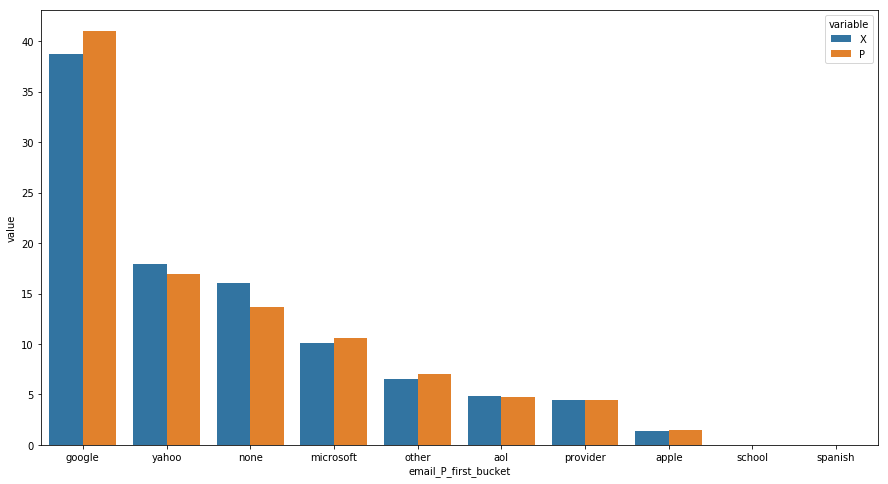

In [52]:
plot_bar_col_norm_values(X, P, 'email_P_first_bucket')

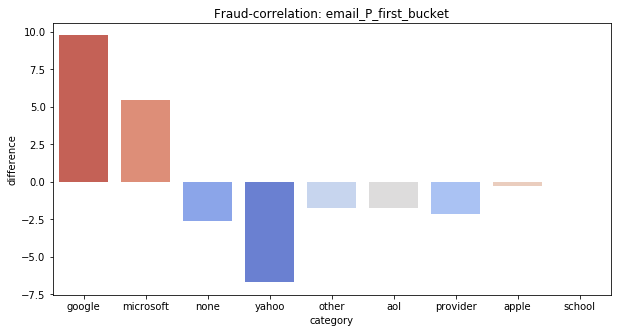

In [53]:
plot_fraud_correlation(X, 'email_P_first_bucket')

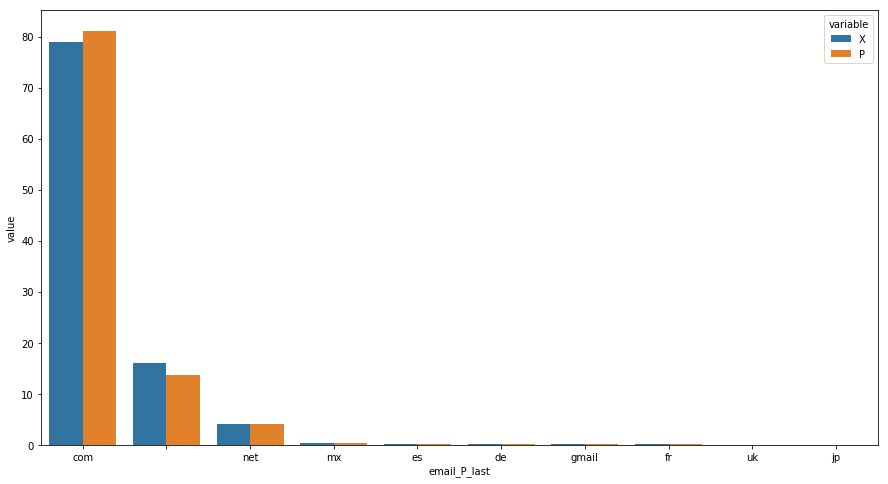

In [54]:
plot_bar_col_norm_values(X, P, 'email_P_last')

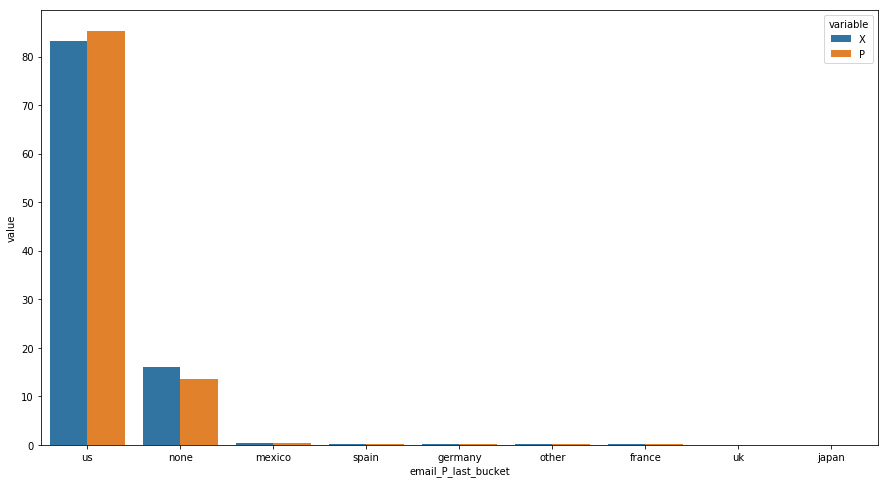

In [55]:
plot_bar_col_norm_values(X, P, 'email_P_last_bucket')

**2.6: EDA - Product Features**    
We have **1** **ProductCD** feature stored as a *string* type.

* **72%** of the contents are a single repeating value (**W**)
* There are 5 types of categories: (**W, C, R, H, S**)

**X: ProductCD**

In [56]:
X['ProductCD'].value_counts(dropna=True).to_frame().head(5)

,ProductCD
W,439670
C,68519
R,37699
H,33024
S,11628


**P: ProductCD**

In [57]:
P['ProductCD'].value_counts(dropna=True).to_frame().head(5)

,ProductCD
W,360987
C,69266
R,35647
H,29373
S,11418


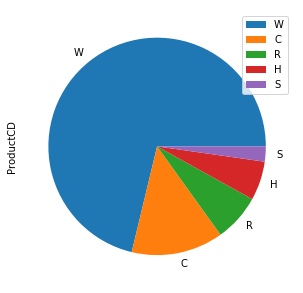

In [58]:
P['ProductCD'].value_counts(dropna=True).to_frame().plot.pie(y='ProductCD', figsize=(5, 5))

In [59]:
plot_violin(X[X['Amt_dollars'] < 500], ['ProductCD', 'Amt_dollars'], ['type', 'amount'])

KeyError: 'Amt_dollars'

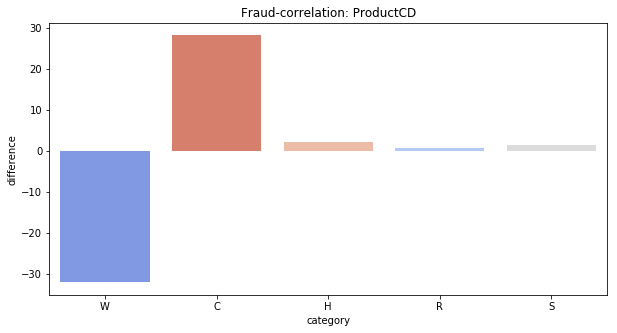

In [60]:
plot_fraud_correlation(X, 'ProductCD')

We can number these **Product** features by frequency.

In [61]:
product_LUT = {
    'W': 1,
    'C': 2,
    'R': 3,
    'H': 4,
    'S': 5
}

X['ProductCD'] = X['ProductCD'].map(lambda x: 0 if x not in product_LUT else product_LUT[x])
P['ProductCD'] = P['ProductCD'].map(lambda x: 0 if x not in product_LUT else product_LUT[x])

X['ProductCD'] = X['ProductCD'].astype(np.int8)
P['ProductCD'] = P['ProductCD'].astype(np.int8)

**2.7: EDA - Device Features**    
We have **2** Device features (**DeviceInfo**, **DeviceType**) stored as a *string* type.

* There are only 2 device types (**desktop, mobile**)

In [62]:
X['DeviceInfo'].value_counts(dropna=True).to_frame().head(5)

,DeviceInfo
Windows,47722
iOS Device,19782
MacOS,12573
Trident/7.0,7440
rv:11.0,1901


In [63]:
def device_short(s):
    if not s or not isinstance(s, str):
        return ''
    short_name = s.lower()
    short_name = re.sub(r'[^a-z\s]', '', short_name).split(' ')[0]
    if short_name[0:2] == 'sm':
        return 'samsung'
    elif short_name[0:2] == 'lg':
        return 'lg'
    elif short_name[0:3] == 'mac':
        return 'ios'
    
    return short_name

def device_abbrev(s):
    if not s or not isinstance(s, str):
        return ''
    nameList = re.split('[^a-zA-Z]', s)
    nameList = list(filter(lambda x: len(x) > 1, nameList))
    if len(nameList) == 0:
        return ''
    name = nameList[0].lower()
    if name == 'samsung':
        name = 'sm'
    elif name[0:3] == 'mac':
        return 'ios'
    return name[0:3]

def device_bucket_name(s):
    if not s or not isinstance(s, str):
        return 'none'

    buckets = {
        '': 'none',
        'windows': 'microsoft',
        'ios': 'apple',
        'samsung': 'samsung',
        'trident': 'trident',
        'rv': 'rv',
        'moto': 'motorola',
        'lg': 'lg',
        'huawei': 'huawei',
    }
    
    return buckets.get(s, 'other')

def device_bucket_abbrev(s):
    if not s or not isinstance(s, str):
        return 'none'

    buckets = {
        '': 'none',
        'win': 'microsoft',
        'ios': 'apple',
        'sm': 'samsung',
        'tri': 'trident',
        'rv': 'rv',
        'mot': 'motorola',
        'lg': 'lg',
        'hua': 'huawei'
    }
    
    return buckets.get(s, 'other')

def add_device_buckets(df):
    df['Device_short_bucket'] = df['Device_short'].map(device_bucket_name)
    df['Device_abbrev_bucket'] = df['Device_abbrev'].map(device_bucket_abbrev)

def add_device_features(df):
    df['Device_short'] = df['DeviceInfo'].map(device_short)
    df['Device_abbrev'] = df['DeviceInfo'].map(device_abbrev)
    
add_device_features(X)
add_device_features(P)
add_device_buckets(X)
add_device_buckets(P)

features = remove_features(features, ['DeviceInfo', 'DeviceInfo'])
features_grouped = get_feature_groups(features)

features_engineered = features_engineered + ['Device_short', 'Device_abbrev', 'Device_short_bucket', 'Device_abbrev_bucket']

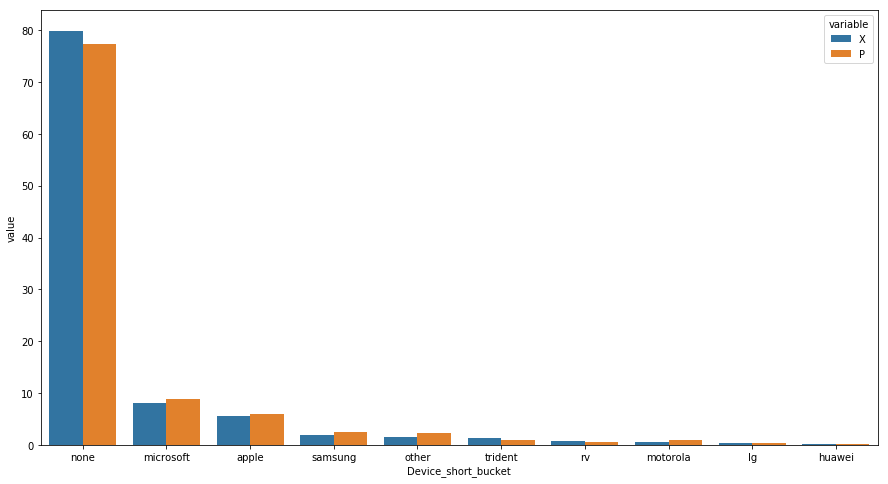

In [64]:
plot_bar_col_norm_values(X, P, 'Device_short_bucket')

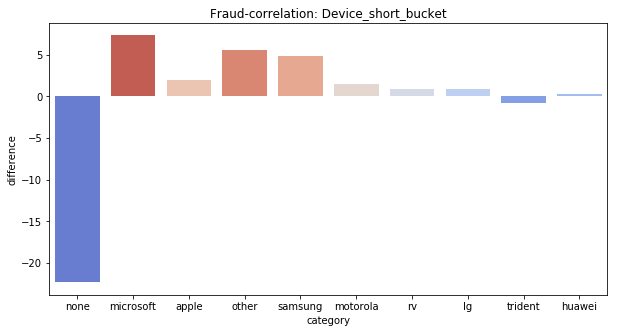

In [65]:
plot_fraud_correlation(X, 'Device_short_bucket')

**X: DeviceType**

In [66]:
X['DeviceType'].value_counts(dropna=True).to_frame()

,DeviceType
desktop,85165
mobile,55645


**P: DeviceType**

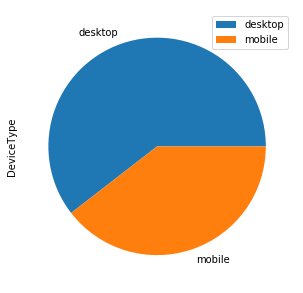

In [67]:
X['DeviceType'].value_counts(dropna=True).to_frame().plot.pie(y='DeviceType', figsize=(5, 5))

In [68]:
device_LUT = {
    'desktop': 1,
    'mobile': 2
}

X['DeviceType'] = X['DeviceType'].map(lambda x: 0 if x not in device_LUT else device_LUT[x])
P['DeviceType'] = P['DeviceType'].map(lambda x: 0 if x not in device_LUT else device_LUT[x])

X['DeviceType'] = X['DeviceType'].astype(np.int8)
P['DeviceType'] = P['DeviceType'].astype(np.int8)

**2.8: EDA - Transaction Features**    
We have **3** Transaction features (**TransactionID, TransactionDT, TransactionAmt**) stored as *mixed* types.

* We'll need our test set **TransactionID** for submission, but it won't be of any use during training.

In [69]:
# TransactionIDs aren't repeated.
print('Transaction IDs are reused no more than {} time.'.format(X['TransactionID'].value_counts().tolist()[0]))

features = remove_features(features, ['TransactionID'])
features_grouped = get_feature_groups(features)

Transaction IDs are reused no more than 1 time.


Our transaction amounts are skewed far to the lower end of our chart.

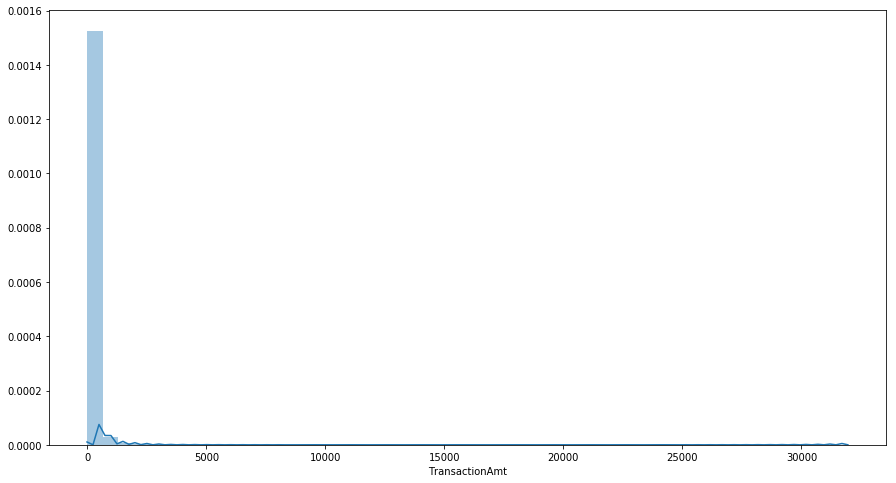

In [70]:
plt.figure(figsize=(15,8))
sns.distplot(X['TransactionAmt'])

Let's separate the decimal values and the last 2 digits, then convert these to log-scale.

In [71]:
def dollar_sep(n):
    s = str(n).split('.')[0]
    return int(s)

def change_sep(n):
    return int(decimal_sep(n) * 100)

def penny_sep(n):
    return int(str(change_sep(n)).zfill(2)[1])

def dime_sep(n):
    return int(str(change_sep(n)).zfill(2)[0])

def one_sep(n):
    s = str(n).split('.')[0][-1::].zfill(1)
    return int(s[0])

def ten_sep(n):
    s = str(n).split('.')[0][-2::].zfill(2)
    return int(s[0])

X['Amt_dollars'] = X['TransactionAmt'].map(dollar_sep)
X['Amt_change'] = X['TransactionAmt'].map(change_sep)
X['Amt_penny'] = X['TransactionAmt'].map(penny_sep)
X['Amt_dime'] = X['TransactionAmt'].map(dime_sep)
X['Amt_one'] = X['TransactionAmt'].map(one_sep)
X['Amt_ten'] = X['TransactionAmt'].map(ten_sep)
X['Amt_log'] = X['TransactionAmt'].map(lambda x: 0 if x == 0 else np.log(x))

P['Amt_dollars'] = P['TransactionAmt'].map(dollar_sep)
P['Amt_change'] = P['TransactionAmt'].map(change_sep)
P['Amt_penny'] = P['TransactionAmt'].map(penny_sep)
P['Amt_dime'] = P['TransactionAmt'].map(dime_sep)
P['Amt_one'] = P['TransactionAmt'].map(one_sep)
P['Amt_ten'] = P['TransactionAmt'].map(ten_sep)
P['Amt_log'] = P['TransactionAmt'].map(lambda x: 0 if x == 0 else np.log(x))

X['TransactionAmt'].fillna(-1, inplace=True)
P['TransactionAmt'].fillna(-1, inplace=True)

features = remove_features(features, ['TransactionAmt'])
features_grouped = get_feature_groups(features)

features_engineered = features_engineered + ['Amt_dollars', 'Amt_change', 'Amt_penny', 'Amt_dime',
                                             'Amt_one', 'Amt_ten', 'Amt_log']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


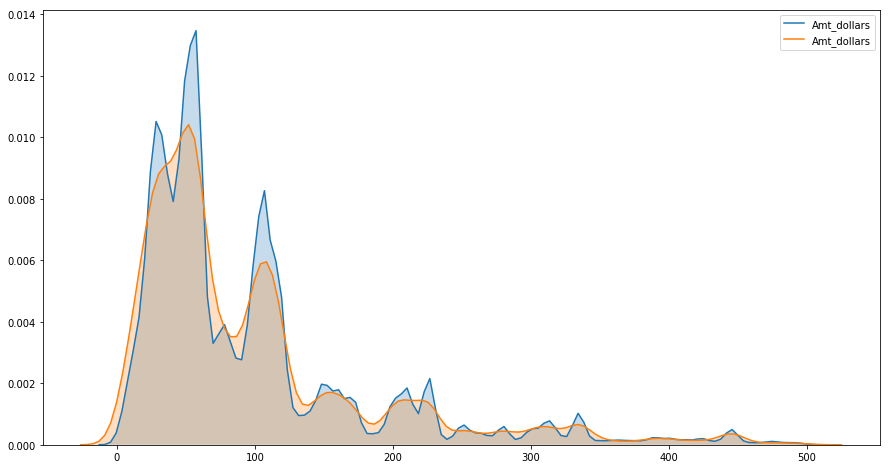

In [72]:
plt.figure(figsize=(15,8))
sns.kdeplot(X[(X['isFraud']==0) & (X['Amt_dollars'] < 500)]['Amt_dollars'], shade=True)
sns.kdeplot(P[(X['isFraud']==1) & (P['Amt_dollars'] < 500)]['Amt_dollars'], shade=True)

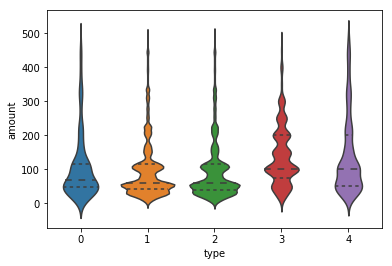

In [73]:
plot_violin(X[X['Amt_dollars'] < 500], ['card4', 'Amt_dollars'], ['type', 'amount'])

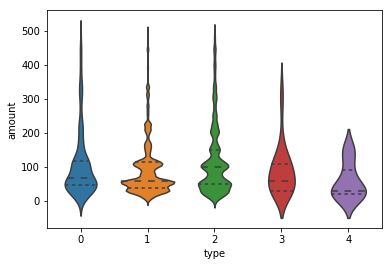

In [74]:
plot_violin(X[X['Amt_dollars'] < 500], ['card6', 'Amt_dollars'], ['type', 'amount'])

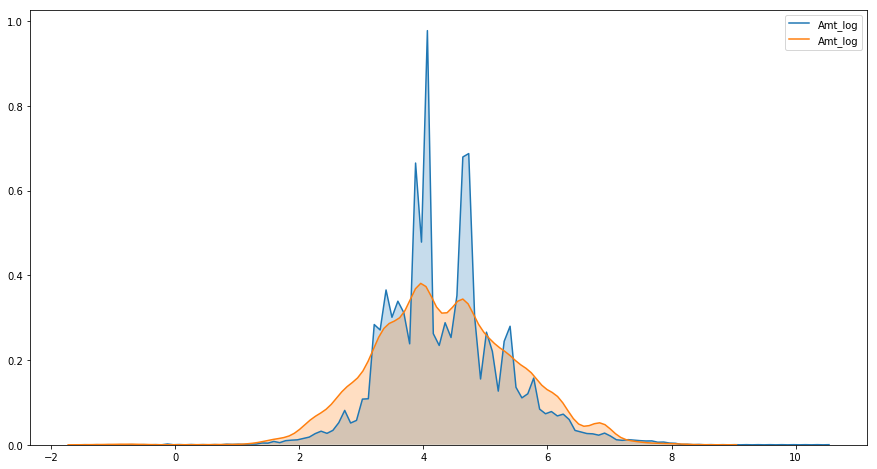

In [75]:
plt.figure(figsize=(15,8))
sns.kdeplot(X[X['isFraud']==0]['Amt_log'], shade=True)
sns.kdeplot(X[X['isFraud']==1]['Amt_log'], shade=True)

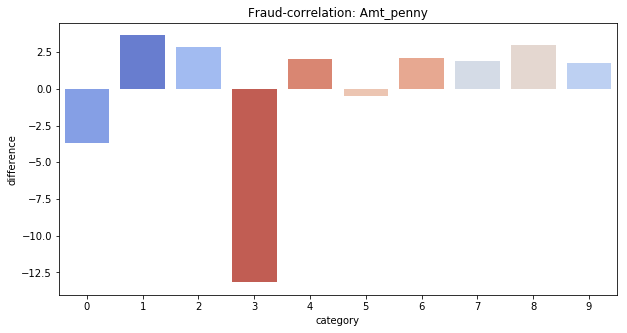

In [76]:
plot_fraud_correlation(X, 'Amt_penny')

The highest % of fraud occurs just north of $50.00. There's a slight correlation with addr1 and amt_log.

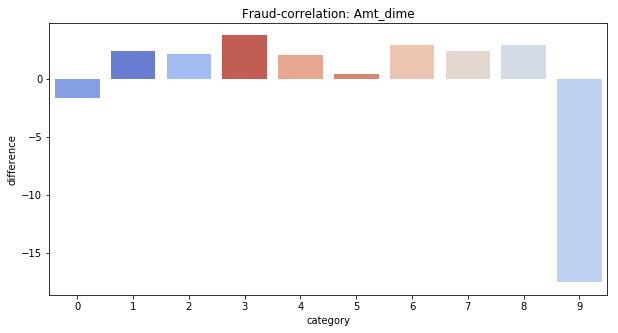

In [77]:
plot_fraud_correlation(X, 'Amt_dime')

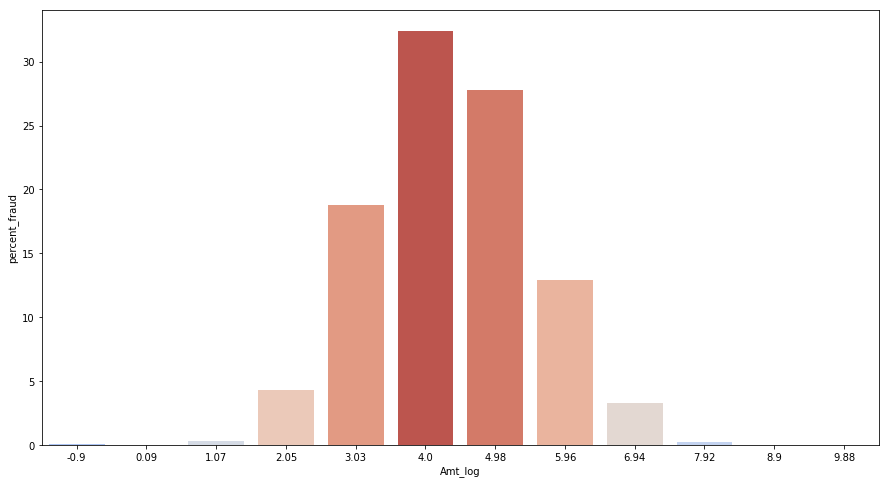

In [78]:
def plot_fraud_bin(df, c, bins=12):
    bins_df = df[[c, 'isFraud']][c].value_counts(bins=bins).to_frame()
    for i in bins_df.index:
        fraud_count = df[(df[c] > i.left) & (df[c] <= i.right)]['isFraud'].sum()
        bins_df.loc[i, c] = round((i.left + i.right) / 2 * 100) / 100
        bins_df.loc[i, 'isFraud'] = fraud_count
    fraud_total = bins_df['isFraud'].sum()
    for i in bins_df.index:
        fraud_perc = bins_df.loc[i, 'isFraud'] / fraud_total * 100.0
        bins_df.loc[i, 'percent_fraud'] = fraud_perc
    bins_df = bins_df.sort_values(by=[c])
    bins_df.reset_index(inplace=True)
    bins_df = bins_df.drop('index', 1)

    fraud_bins = bins_df[[c, 'percent_fraud']]
    pal = sns.color_palette('coolwarm', len(fraud_bins))
    rank = fraud_bins['percent_fraud'].values.argsort().argsort()

    plt.figure(figsize=(15,8))
    sns.barplot(x=c, y='percent_fraud', palette=np.array(pal)[rank], data=fraud_bins, ci=None)
    
plot_fraud_bin(X, 'Amt_log')

**2.9: EDA - Time Features**

In [79]:
# TransactionDTs show some repetition
print('Transaction DTs are reused no more than {} times.'.format(X['TransactionDT'].value_counts().tolist()[0]))

Transaction DTs are reused no more than 8 times.


In [80]:
def hour_hist(hr):
    low_hours = [6, 7, 8, 9, 10, 11, 12]
    med_hours = [2, 3, 4, 5, 13, 14, 15, 16]
    hi_hours = [0, 1, 17, 18, 19, 20, 21, 22, 23]
    
    if hr in low_hours:
        return 1
    elif hr in med_hours:
        return 2
    else:
        return 3
    
def add_time_hist_hr_features(df):
    df['DT_H_Dist'] = df['DT_H'].map(hour_hist)

def add_time_features(df):
    START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
    dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
    us_holidays = holiday_cal().holidays(start=dates_range.min(), end=dates_range.max())

    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_Min'] = (df['DT'].dt.minute).astype(np.int8)
    df['DT_H'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_D'] = (df['DT'].dt.day).astype(np.int16)
    df['DT_DW'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_W'] = (df['DT'].dt.week).astype(np.int8)
    df['DT_WM'] = (df['DT'].apply(lambda d: (d.day-1) // 7 + 1)).astype(np.int8)
    df['DT_M'] = (df['DT'].dt.month).astype(np.int8)
    df['DT_Holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    
add_time_features(X)
add_time_features(P)
add_time_hist_hr_features(X)
add_time_hist_hr_features(P)

features_engineered = features_engineered + ['DT_Min', 'DT_H', 'DT_D', 'DT_DW', 'DT_W', 'DT_WM',
                                             'DT_M', 'DT_H', 'DT_Holiday', 'DT_H_Dist']

Most of our timestamps occur soon after each other. But there are a few with a much longer pause.

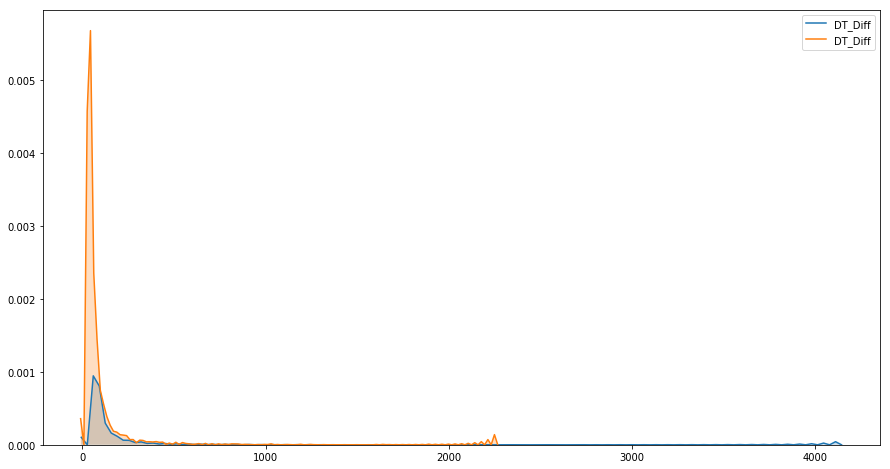

In [81]:
# Delta between timestamps.
X['DT_Diff'] = X['TransactionDT'].diff()
P['DT_Diff'] = P['TransactionDT'].diff()

X['DT_Diff'].fillna(-1, inplace=True)
P['DT_Diff'].fillna(-1, inplace=True)

plt.figure(figsize=(15,8))
sns.kdeplot(X[X['isFraud']==0]['DT_Diff'], shade=True)
sns.kdeplot(X[X['isFraud']==1]['DT_Diff'], shade=True)

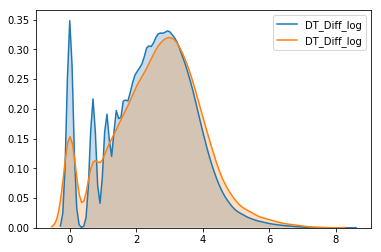

In [82]:
X['DT_Diff_log'] = X['DT_Diff'].map(lambda x: 0 if x <= 0 else np.log(x))
P['DT_Diff_log'] = P['DT_Diff'].map(lambda x: 0 if x <= 0 else np.log(x))

features_engineered = features_engineered + ['DT_Diff_log']

features = remove_features(features, ['DT_Diff', 'TransactionDT'])
features_grouped = get_feature_groups(features)

sns.kdeplot(X[X['isFraud']==0]['DT_Diff_log'], shade=True)
sns.kdeplot(X[X['isFraud']==1]['DT_Diff_log'], shade=True)

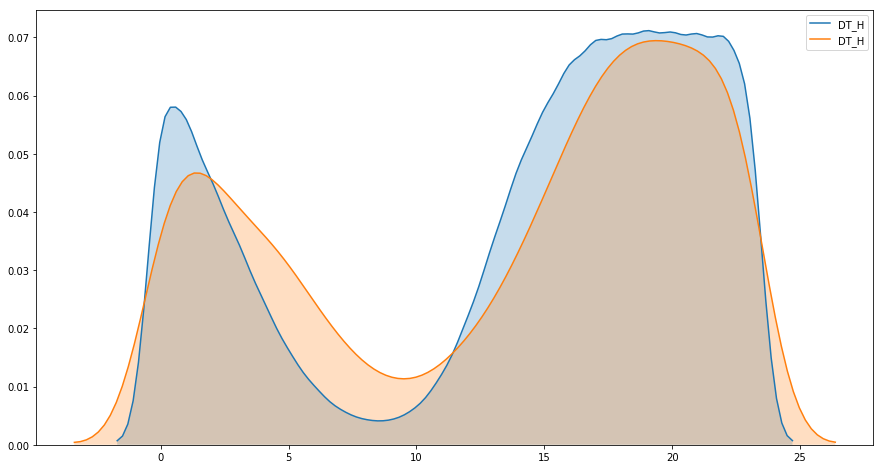

In [83]:
plt.figure(figsize=(15,8))
sns.kdeplot(X[X['isFraud']==0]['DT_H'], shade=True)
sns.kdeplot(X[X['isFraud']==1]['DT_H'], shade=True)

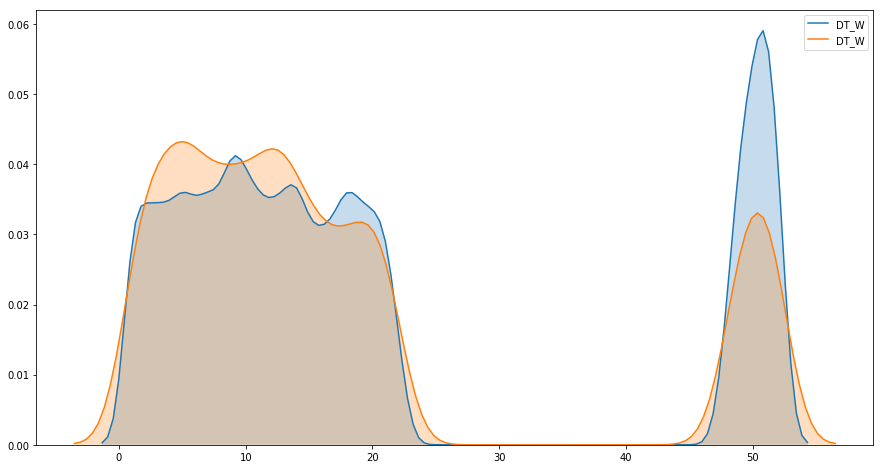

In [84]:
plt.figure(figsize=(15,8))
sns.kdeplot(X[X['isFraud']==0]['DT_W'], shade=True)
sns.kdeplot(X[X['isFraud']==1]['DT_W'], shade=True)

**2.10: EDA - ID Features**

In [85]:
print(features_grouped['id'])

['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_32', 'id_35', 'id_36', 'id_37', 'id_38']


In [86]:
check_types([X, P], 'id_01')

X['id_01'].fillna(0, inplace=True)
P['id_01'].fillna(0, inplace=True)

fix_floats_col(X, 'id_01')
fix_floats_col(P, 'id_01')

id_01 min-range: [-100.0, -100.0]
id_01 max-range: [0.0, 0.0]
id_01 unused negative space: [False, False]
id_01 unused positive space: [False, False]
id_01 unused zeros: [False, False]
id_01 is integer: [True, True]


In [87]:
check_types([X, P], 'id_02')

X['id_02'].fillna(-1, inplace=True)
P['id_02'].fillna(-1, inplace=True)

fix_floats_col(X, 'id_02')
fix_floats_col(P, 'id_02')

id_02 min-range: [1.0, 2.0]
id_02 max-range: [999595.0, 999869.0]
id_02 unused negative space: [True, True]
id_02 unused positive space: [False, False]
id_02 unused zeros: [True, True]
id_02 is integer: [True, True]


In [88]:
check_types([X, P], 'id_05')
X['id_05'].fillna(0, inplace=True)
P['id_05'].fillna(0, inplace=True)

fix_floats_col(X, 'id_05')
fix_floats_col(P, 'id_05')

id_05 min-range: [-72.0, -81.0]
id_05 max-range: [52.0, 52.0]
id_05 unused negative space: [False, False]
id_05 unused positive space: [False, False]
id_05 unused zeros: [False, False]
id_05 is integer: [True, True]


In [89]:
check_types([X, P], 'id_06')
X['id_06'].fillna(0, inplace=True)
P['id_06'].fillna(0, inplace=True)

fix_floats_col(X, 'id_06')
fix_floats_col(P, 'id_06')

id_06 min-range: [-100.0, -100.0]
id_06 max-range: [0.0, 0.0]
id_06 unused negative space: [False, False]
id_06 unused positive space: [False, False]
id_06 unused zeros: [False, False]
id_06 is integer: [True, True]


In [90]:
check_types([X, P], 'id_11')

X['id_11'].fillna(-1, inplace=True)
P['id_11'].fillna(-1, inplace=True)

fix_floats_col(X, 'id_11')
fix_floats_col(P, 'id_11')

id_11 min-range: [90.0, 90.0]
id_11 max-range: [100.0, 100.0]
id_11 unused negative space: [True, True]
id_11 unused positive space: [False, False]
id_11 unused zeros: [True, True]
id_11 is integer: [True, True]


In [91]:
print(X['id_12'].unique())
print(P['id_12'].unique())

found_not_LUT = {
    'NotFound': 1,
    'Found': 2
}

X['id_12'] = X['id_12'].map(lambda x: 0 if x not in found_not_LUT else found_not_LUT[x])
P['id_12'] = P['id_12'].map(lambda x: 0 if x not in found_not_LUT else found_not_LUT[x])

X['id_12'] = X['id_12'].astype(np.int8)
P['id_12'] = P['id_12'].astype(np.int8)

[nan 'NotFound' 'Found']
[nan 'NotFound' 'Found']


In [92]:
check_types([X, P], 'id_13')

X['id_13'].fillna(0, inplace=True)
P['id_13'].fillna(0, inplace=True)

fix_floats_col(X, 'id_13')
fix_floats_col(P, 'id_13')

id_13 min-range: [10.0, 11.0]
id_13 max-range: [64.0, 63.0]
id_13 unused negative space: [True, True]
id_13 unused positive space: [False, False]
id_13 unused zeros: [True, True]
id_13 is integer: [True, True]


In [93]:
print(X['id_15'].unique())
print(P['id_15'].unique())

found_new_unknown_LUT = {
    'New': 1,
    'Found': 2,
    'Unknown': 3
}

X['id_15'] = X['id_15'].map(lambda x: 0 if x not in found_new_unknown_LUT else found_new_unknown_LUT[x])
P['id_15'] = P['id_15'].map(lambda x: 0 if x not in found_new_unknown_LUT else found_new_unknown_LUT[x])

X['id_15'] = X['id_15'].astype(np.int8)
P['id_15'] = P['id_15'].astype(np.int8)

[nan 'New' 'Found' 'Unknown']
[nan 'New' 'Found' 'Unknown']


In [94]:
print(X['id_16'].unique())
print(P['id_16'].unique())

X['id_16'] = X['id_16'].map(lambda x: 0 if x not in found_not_LUT else found_not_LUT[x])
P['id_16'] = P['id_16'].map(lambda x: 0 if x not in found_not_LUT else found_not_LUT[x])

X['id_16'] = X['id_16'].astype(np.int8)
P['id_16'] = P['id_16'].astype(np.int8)

[nan 'NotFound' 'Found']
[nan 'NotFound' 'Found']


In [95]:
check_types([X, P], 'id_17')

X['id_17'].fillna(0, inplace=True)
P['id_17'].fillna(0, inplace=True)

fix_floats_col(X, 'id_17')
fix_floats_col(P, 'id_17')

id_17 min-range: [100.0, 100.0]
id_17 max-range: [229.0, 228.0]
id_17 unused negative space: [True, True]
id_17 unused positive space: [False, False]
id_17 unused zeros: [True, True]
id_17 is integer: [True, True]


In [96]:
check_types([X, P], 'id_19')
X['id_19'].fillna(0, inplace=True)
P['id_19'].fillna(0, inplace=True)

fix_floats_col(X, 'id_19')
fix_floats_col(P, 'id_19')

id_19 min-range: [100.0, 100.0]
id_19 max-range: [671.0, 670.0]
id_19 unused negative space: [True, True]
id_19 unused positive space: [False, False]
id_19 unused zeros: [True, True]
id_19 is integer: [True, True]


In [97]:
check_types([X, P], 'id_20')

X['id_20'].fillna(0, inplace=True)
P['id_20'].fillna(0, inplace=True)

fix_floats_col(X, 'id_20')
fix_floats_col(P, 'id_20')

id_20 min-range: [100.0, 100.0]
id_20 max-range: [661.0, 660.0]
id_20 unused negative space: [True, True]
id_20 unused positive space: [False, False]
id_20 unused zeros: [True, True]
id_20 is integer: [True, True]


In [98]:
print(X['id_28'].unique())
print(P['id_28'].unique())

found_new_LUT = {
    'New': 1,
    'Found': 2
}

X['id_28'] = X['id_28'].map(lambda x: 0 if x not in found_new_LUT else found_new_LUT[x])
P['id_28'] = P['id_28'].map(lambda x: 0 if x not in found_new_LUT else found_new_LUT[x])

X['id_28'] = X['id_28'].astype(np.int8)
P['id_28'] = P['id_28'].astype(np.int8)

[nan 'New' 'Found']
[nan 'New' 'Found']


In [99]:
print(X['id_29'].unique())
print(P['id_29'].unique())

X['id_29'] = X['id_29'].map(lambda x: 0 if x not in found_not_LUT else found_not_LUT[x])
P['id_29'] = P['id_29'].map(lambda x: 0 if x not in found_not_LUT else found_not_LUT[x])

X['id_29'] = X['id_29'].astype(np.int8)
P['id_29'] = P['id_29'].astype(np.int8)

[nan 'NotFound' 'Found']
[nan 'NotFound' 'Found']


**id_31** appears to be a new Device feature.

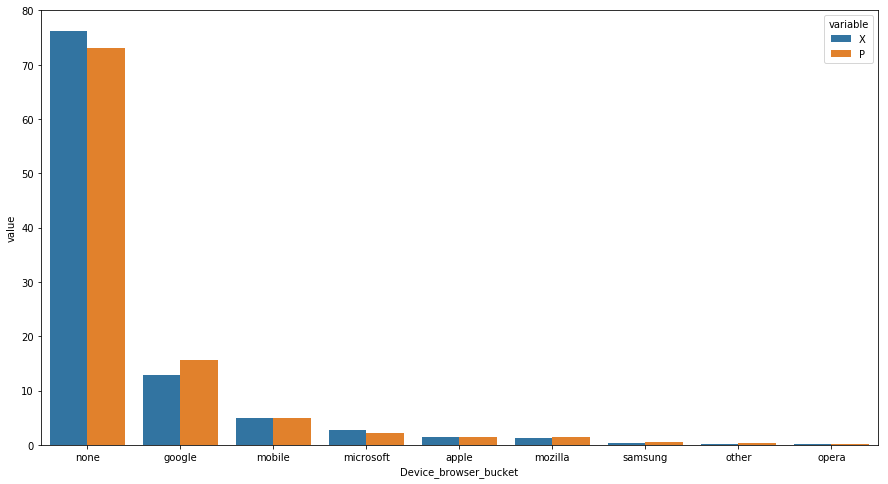

In [100]:
def browser_short(s):
    if not s or not isinstance(s, str):
        return ''
    short_name = s.lower()
    short_name = re.split('[^a-zA-Z]', short_name)[0]
    return short_name

def browser_bucket(s):
    if not s or not isinstance(s, str):
        return 'none'

    buckets = {
        '': 'none',
        'chrome': 'google',
        'mobile': 'mobile',
        'ie': 'microsoft',
        'safari': 'apple',
        'firefox': 'mozilla',
        'edge': 'microsoft',
        'samsung': 'samsung',
        'opera': 'opera',
        'android': 'mobile'
    }
    
    return buckets.get(s, 'other')

X['Device_browser'] = X['id_31'].map(browser_short)
P['Device_browser'] = P['id_31'].map(browser_short)

X['Device_browser_bucket'] = X['Device_browser'].map(browser_bucket)
P['Device_browser_bucket'] = P['Device_browser'].map(browser_bucket)

features = remove_features(features, ['id_31'])
features_grouped = get_feature_groups(features)

plot_bar_col_norm_values(X, P, 'Device_browser_bucket', 10)

features_engineered = features_engineered + ['Device_browser', 'Device_browser_bucket']

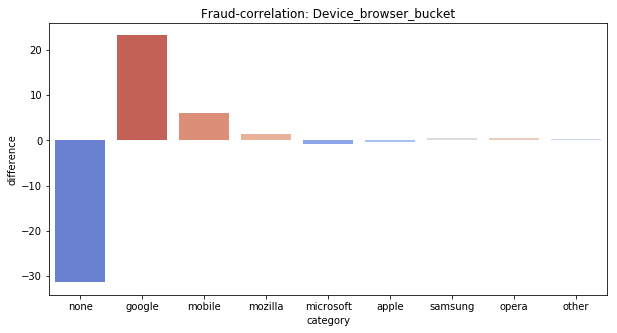

In [101]:
plot_fraud_correlation(X, 'Device_browser_bucket')

The values in **id_32** are multiples of 8, so let's reduce those.

In [102]:
check_types([X, P], 'id_32')

X['id_32'].fillna(-8, inplace=True)
P['id_32'].fillna(-8, inplace=True)

X['id_32'] = X['id_32'].map(lambda x: int(x = x / 4))
P['id_32'] = P['id_32'].map(lambda x: int(x = x / 4))

fix_floats_col(X, 'id_32')
fix_floats_col(P, 'id_32')

id_32 min-range: [0.0, 8.0]
id_32 max-range: [32.0, 48.0]
id_32 unused negative space: [True, True]
id_32 unused positive space: [False, False]
id_32 unused zeros: [False, True]
id_32 is integer: [True, True]


In [103]:
print(X['id_35'].unique())
print(P['id_35'].unique())

tf_LUT = {
    'T': 1,
    'F': 2
}

X['id_35'] = X['id_35'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['id_35'] = P['id_35'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['id_35'] = X['id_35'].astype(np.int8)
P['id_35'] = P['id_35'].astype(np.int8)

[nan 'T' 'F']
[nan 'F' 'T']


In [104]:
print(X['id_36'].unique())
print(P['id_36'].unique())

X['id_36'] = X['id_36'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['id_36'] = P['id_36'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['id_36'] = X['id_36'].astype(np.int8)
P['id_36'] = P['id_36'].astype(np.int8)

[nan 'F' 'T']
[nan 'F' 'T']


In [105]:
print(X['id_37'].unique())
print(P['id_37'].unique())

X['id_37'] = X['id_37'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['id_37'] = P['id_37'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['id_37'] = X['id_37'].astype(np.int8)
P['id_37'] = P['id_37'].astype(np.int8)

[nan 'T' 'F']
[nan 'T' 'F']


In [106]:
print(X['id_38'].unique())
print(P['id_38'].unique())

X['id_38'] = X['id_38'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['id_38'] = P['id_38'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['id_38'] = X['id_38'].astype(np.int8)
P['id_38'] = P['id_38'].astype(np.int8)

[nan 'T' 'F']
[nan 'F' 'T']


**2.11: EDA - C Features**

In [107]:
check_types([X, P], 'C1')

X['C1'].fillna(-1, inplace=True)
P['C1'].fillna(-1, inplace=True)

fix_floats_col(X, 'C1')
fix_floats_col(P, 'C1')

C1 min-range: [0.0, 0.0]
C1 max-range: [4684.0, 2950.0]
C1 unused negative space: [True, True]
C1 unused positive space: [False, False]
C1 unused zeros: [False, False]
C1 is integer: [True, True]


In [108]:
check_types([X, P], 'C10')

X['C10'].fillna(-1, inplace=True)
P['C10'].fillna(-1, inplace=True)

fix_floats_col(X, 'C10')
fix_floats_col(P, 'C10')

C10 min-range: [0.0, 0.0]
C10 max-range: [3256.0, 881.0]
C10 unused negative space: [True, True]
C10 unused positive space: [False, False]
C10 unused zeros: [False, False]
C10 is integer: [True, True]


In [109]:
check_types([X, P], 'C11')

X['C11'].fillna(-1, inplace=True)
P['C11'].fillna(-1, inplace=True)

fix_floats_col(X, 'C11')
fix_floats_col(P, 'C11')

C11 min-range: [0.0, 0.0]
C11 max-range: [3188.0, 2234.0]
C11 unused negative space: [True, True]
C11 unused positive space: [False, False]
C11 unused zeros: [False, False]
C11 is integer: [True, True]


In [110]:
check_types([X, P], 'C12')

X['C12'].fillna(-1, inplace=True)
P['C12'].fillna(-1, inplace=True)

fix_floats_col(X, 'C12')
fix_floats_col(P, 'C12')

C12 min-range: [0.0, 0.0]
C12 max-range: [3188.0, 2234.0]
C12 unused negative space: [True, True]
C12 unused positive space: [False, False]
C12 unused zeros: [False, False]
C12 is integer: [True, True]


In [111]:
check_types([X, P], 'C13')

X['C13'].fillna(-1, inplace=True)
P['C13'].fillna(-1, inplace=True)

fix_floats_col(X, 'C13')
fix_floats_col(P, 'C13')

C13 min-range: [0.0, 0.0]
C13 max-range: [2918.0, 1562.0]
C13 unused negative space: [True, True]
C13 unused positive space: [False, False]
C13 unused zeros: [False, False]
C13 is integer: [True, True]


In [112]:
check_types([X, P], 'C14')

X['C14'].fillna(-1, inplace=True)
P['C14'].fillna(-1, inplace=True)

fix_floats_col(X, 'C14')
fix_floats_col(P, 'C14')

C14 min-range: [0.0, 0.0]
C14 max-range: [1429.0, 797.0]
C14 unused negative space: [True, True]
C14 unused positive space: [False, False]
C14 unused zeros: [False, False]
C14 is integer: [True, True]


In [113]:
check_types([X, P], 'C2')

X['C2'].fillna(-1, inplace=True)
P['C2'].fillna(-1, inplace=True)

fix_floats_col(X, 'C2')
fix_floats_col(P, 'C2')

C2 min-range: [0.0, 0.0]
C2 max-range: [5692.0, 3276.0]
C2 unused negative space: [True, True]
C2 unused positive space: [False, False]
C2 unused zeros: [False, False]
C2 is integer: [True, True]


In [114]:
check_types([X, P], 'C3')

X['C3'].fillna(-1, inplace=True)
P['C3'].fillna(-1, inplace=True)

fix_floats_col(X, 'C3')
fix_floats_col(P, 'C3')

C3 min-range: [0.0, 0.0]
C3 max-range: [26.0, 31.0]
C3 unused negative space: [True, True]
C3 unused positive space: [False, False]
C3 unused zeros: [False, False]
C3 is integer: [True, True]


In [115]:
check_types([X, P], 'C4')

X['C4'].fillna(-1, inplace=True)
P['C4'].fillna(-1, inplace=True)

fix_floats_col(X, 'C4')
fix_floats_col(P, 'C4')

C4 min-range: [0.0, 0.0]
C4 max-range: [2252.0, 1601.0]
C4 unused negative space: [True, True]
C4 unused positive space: [False, False]
C4 unused zeros: [False, False]
C4 is integer: [True, True]


In [116]:
check_types([X, P], 'C5')

X['C5'].fillna(-1, inplace=True)
P['C5'].fillna(-1, inplace=True)

fix_floats_col(X, 'C5')
fix_floats_col(P, 'C5')

C5 min-range: [0.0, 0.0]
C5 max-range: [349.0, 376.0]
C5 unused negative space: [True, True]
C5 unused positive space: [False, False]
C5 unused zeros: [False, False]
C5 is integer: [True, True]


In [117]:
check_types([X, P], 'C6')

X['C6'].fillna(-1, inplace=True)
P['C6'].fillna(-1, inplace=True)

fix_floats_col(X, 'C6')
fix_floats_col(P, 'C6')

C6 min-range: [0.0, 0.0]
C6 max-range: [2252.0, 1601.0]
C6 unused negative space: [True, True]
C6 unused positive space: [False, False]
C6 unused zeros: [False, False]
C6 is integer: [True, True]


In [118]:
check_types([X, P], 'C7')

X['C7'].fillna(-1, inplace=True)
P['C7'].fillna(-1, inplace=True)

fix_floats_col(X, 'C7')
fix_floats_col(P, 'C7')

C7 min-range: [0.0, 0.0]
C7 max-range: [2256.0, 1621.0]
C7 unused negative space: [True, True]
C7 unused positive space: [False, False]
C7 unused zeros: [False, False]
C7 is integer: [True, True]


In [119]:
check_types([X, P], 'C8')

X['C8'].fillna(-1, inplace=True)
P['C8'].fillna(-1, inplace=True)

fix_floats_col(X, 'C8')
fix_floats_col(P, 'C8')

C8 min-range: [0.0, 0.0]
C8 max-range: [3332.0, 1005.0]
C8 unused negative space: [True, True]
C8 unused positive space: [False, False]
C8 unused zeros: [False, False]
C8 is integer: [True, True]


In [120]:
check_types([X, P], 'C9')

X['C9'].fillna(-1, inplace=True)
P['C9'].fillna(-1, inplace=True)

fix_floats_col(X, 'C9')
fix_floats_col(P, 'C9')

C9 min-range: [0.0, 0.0]
C9 max-range: [210.0, 572.0]
C9 unused negative space: [True, True]
C9 unused positive space: [False, False]
C9 unused zeros: [False, False]
C9 is integer: [True, True]


**2.12: EDA - D Features**

In [121]:
check_types([X, P], 'D1')

X['D1'].fillna(-1, inplace=True)
P['D1'].fillna(-1, inplace=True)

fix_floats_col(X, 'D1')
fix_floats_col(P, 'D1')

D1 min-range: [0.0, 0.0]
D1 max-range: [640.0, 641.0]
D1 unused negative space: [True, True]
D1 unused positive space: [False, False]
D1 unused zeros: [False, False]
D1 is integer: [True, True]


In [122]:
check_types([X, P], 'D10')

X['D10'].fillna(-1, inplace=True)
P['D10'].fillna(-1, inplace=True)

fix_floats_col(X, 'D10')
fix_floats_col(P, 'D10')

D10 min-range: [0.0, 0.0]
D10 max-range: [876.0, 1091.0]
D10 unused negative space: [True, True]
D10 unused positive space: [False, False]
D10 unused zeros: [False, False]
D10 is integer: [True, True]


In [123]:
check_types([X, P], 'D11')

X['D11'].fillna(-1, inplace=True)
P['D11'].fillna(-1, inplace=True)

fix_floats_col(X, 'D11')
fix_floats_col(P, 'D11')

D11 min-range: [-53.0, 0.0]
D11 max-range: [670.0, 883.0]
D11 unused negative space: [False, True]
D11 unused positive space: [False, False]
D11 unused zeros: [False, False]
D11 is integer: [True, True]


In [124]:
check_types([X, P], 'D12')

X['D12'].fillna(-1, inplace=True)
P['D12'].fillna(-1, inplace=True)

fix_floats_col(X, 'D12')
fix_floats_col(P, 'D12')

D12 min-range: [-83.0, 0.0]
D12 max-range: [648.0, 879.0]
D12 unused negative space: [False, True]
D12 unused positive space: [False, False]
D12 unused zeros: [False, False]
D12 is integer: [True, True]


In [125]:
check_types([X, P], 'D13')

X['D13'].fillna(-1, inplace=True)
P['D13'].fillna(-1, inplace=True)

fix_floats_col(X, 'D13')
fix_floats_col(P, 'D13')

D13 min-range: [0.0, 0.0]
D13 max-range: [847.0, 1066.0]
D13 unused negative space: [True, True]
D13 unused positive space: [False, False]
D13 unused zeros: [False, False]
D13 is integer: [True, True]


In [126]:
check_types([X, P], 'D14')

X['D14'].fillna(-1, inplace=True)
P['D14'].fillna(-1, inplace=True)

fix_floats_col(X, 'D14')
fix_floats_col(P, 'D14')

D14 min-range: [-193.0, 0.0]
D14 max-range: [878.0, 1085.0]
D14 unused negative space: [False, True]
D14 unused positive space: [False, False]
D14 unused zeros: [False, False]
D14 is integer: [True, True]


In [127]:
check_types([X, P], 'D15')

X['D15'].fillna(-1, inplace=True)
P['D15'].fillna(-1, inplace=True)

fix_floats_col(X, 'D15')
fix_floats_col(P, 'D15')

D15 min-range: [-83.0, 0.0]
D15 max-range: [879.0, 1091.0]
D15 unused negative space: [False, True]
D15 unused positive space: [False, False]
D15 unused zeros: [False, False]
D15 is integer: [True, True]


In [128]:
check_types([X, P], 'D2')

X['D2'].fillna(-1, inplace=True)
P['D2'].fillna(-1, inplace=True)

fix_floats_col(X, 'D2')
fix_floats_col(P, 'D2')

D2 min-range: [0.0, 0.0]
D2 max-range: [640.0, 641.0]
D2 unused negative space: [True, True]
D2 unused positive space: [False, False]
D2 unused zeros: [False, False]
D2 is integer: [True, True]


In [129]:
check_types([X, P], 'D3')

X['D3'].fillna(-1, inplace=True)
P['D3'].fillna(-1, inplace=True)

fix_floats_col(X, 'D3')
fix_floats_col(P, 'D3')

D3 min-range: [0.0, 0.0]
D3 max-range: [819.0, 1076.0]
D3 unused negative space: [True, True]
D3 unused positive space: [False, False]
D3 unused zeros: [False, False]
D3 is integer: [True, True]


In [130]:
check_types([X, P], 'D4')

X['D4'].fillna(-1, inplace=True)
P['D4'].fillna(-1, inplace=True)

fix_floats_col(X, 'D4')
fix_floats_col(P, 'D4')

D4 min-range: [-122.0, 0.0]
D4 max-range: [869.0, 1091.0]
D4 unused negative space: [False, True]
D4 unused positive space: [False, False]
D4 unused zeros: [False, False]
D4 is integer: [True, True]


In [131]:
check_types([X, P], 'D5')

X['D5'].fillna(-1, inplace=True)
P['D5'].fillna(-1, inplace=True)

fix_floats_col(X, 'D5')
fix_floats_col(P, 'D5')

D5 min-range: [0.0, 0.0]
D5 max-range: [819.0, 1088.0]
D5 unused negative space: [True, True]
D5 unused positive space: [False, False]
D5 unused zeros: [False, False]
D5 is integer: [True, True]


In [132]:
check_types([X, P], 'D6')

X['D6'].fillna(-1, inplace=True)
P['D6'].fillna(-1, inplace=True)
fix_floats_col(X, 'D6')
fix_floats_col(P, 'D6')

D6 min-range: [-83.0, 0.0]
D6 max-range: [873.0, 1091.0]
D6 unused negative space: [False, True]
D6 unused positive space: [False, False]
D6 unused zeros: [False, False]
D6 is integer: [True, True]


In [133]:
check_types([X, P], 'D8')

X['D8'].fillna(-1, inplace=True)
P['D8'].fillna(-1, inplace=True)
fix_floats_col(X, 'D8')
fix_floats_col(P, 'D8')

D8 min-range: [0.0, 0.0]
D8 max-range: [1708.0, 2030.0]
D8 unused negative space: [True, True]
D8 unused positive space: [False, False]
D8 unused zeros: [False, False]
D8 is integer: [True, True]


In [134]:
check_types([X, P], 'D9')

X['D9'].fillna(-1, inplace=True)
P['D9'].fillna(-1, inplace=True)
fix_floats_col(X, 'D9')
fix_floats_col(P, 'D9')

D9 min-range: [0.0, 0.0]
D9 max-range: [0.9585, 0.9585]
D9 unused negative space: [True, True]
D9 unused positive space: [False, False]
D9 unused zeros: [False, False]
D9 is integer: [False, False]


**2.13: EDA - M Features**

In [135]:
print(X['M1'].unique())
print(P['M1'].unique())

X['M1'] = X['M1'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M1'] = P['M1'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M1'] = X['M1'].astype(np.int8)
P['M1'] = P['M1'].astype(np.int8)

['T' nan 'F']
['T' nan 'F']


In [136]:
print(X['M2'].unique())
print(P['M2'].unique())

X['M2'] = X['M2'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M2'] = P['M2'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M2'] = X['M2'].astype(np.int8)
P['M2'] = P['M2'].astype(np.int8)

['T' nan 'F']
['T' 'F' nan]


In [137]:
print(X['M3'].unique())
print(P['M3'].unique())

X['M3'] = X['M3'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M3'] = P['M3'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M3'] = X['M3'].astype(np.int8)
P['M3'] = P['M3'].astype(np.int8)

['T' nan 'F']
['F' 'T' nan]


In [138]:
print(X['M4'].unique())
print(P['M4'].unique())

m_LUT = {
    'M0': 1,
    'M1': 2,
    'M2': 3,
}

X['M4'] = X['M4'].map(lambda x: 0 if x not in m_LUT else m_LUT[x])
P['M4'] = P['M4'].map(lambda x: 0 if x not in m_LUT else m_LUT[x])

X['M4'] = X['M4'].astype(np.int8)
P['M4'] = P['M4'].astype(np.int8)

['M2' 'M0' nan 'M1']
[nan 'M0' 'M1' 'M2']


In [139]:
print(X['M5'].unique())
print(P['M5'].unique())

X['M5'] = X['M5'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M5'] = P['M5'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M5'] = X['M5'].astype(np.int8)
P['M5'] = P['M5'].astype(np.int8)

['F' 'T' nan]
[nan 'F' 'T']


In [140]:
print(X['M6'].unique())
print(P['M6'].unique())

X['M6'] = X['M6'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M6'] = P['M6'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M6'] = X['M6'].astype(np.int8)
P['M6'] = P['M6'].astype(np.int8)

['T' 'F' nan]
['F' 'T' nan]


In [141]:
print(X['M7'].unique())
print(P['M7'].unique())

X['M7'] = X['M7'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M7'] = P['M7'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M7'] = X['M7'].astype(np.int8)
P['M7'] = P['M7'].astype(np.int8)

[nan 'F' 'T']
['T' nan 'F']


In [142]:
print(X['M8'].unique())
print(P['M8'].unique())

X['M8'] = X['M8'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M8'] = P['M8'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M8'] = X['M8'].astype(np.int8)
P['M8'] = P['M8'].astype(np.int8)

[nan 'F' 'T']
['T' nan 'F']


In [143]:
print(X['M9'].unique())
print(P['M9'].unique())

X['M9'] = X['M9'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])
P['M9'] = P['M9'].map(lambda x: 0 if x not in tf_LUT else tf_LUT[x])

X['M9'] = X['M9'].astype(np.int8)
P['M9'] = P['M9'].astype(np.int8)

[nan 'F' 'T']
['T' nan 'F']


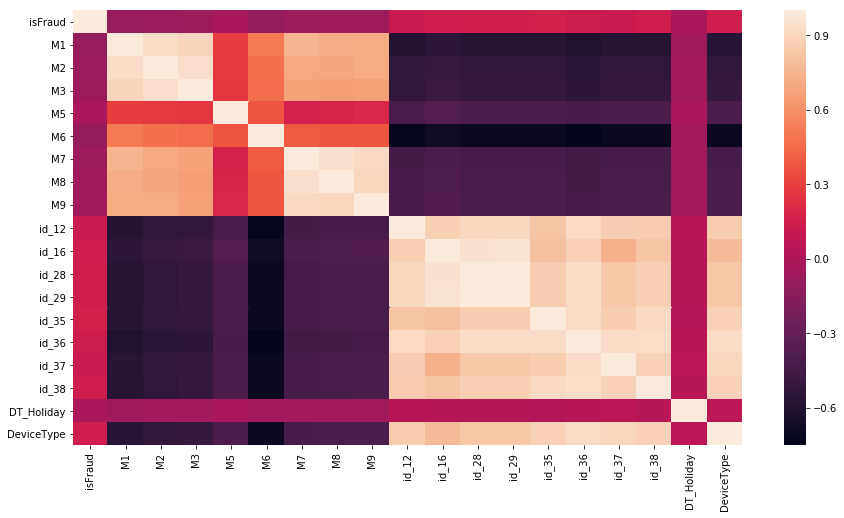

In [144]:
# Boolean features
plt.figure(figsize=(15,8))
sns.heatmap(X[['isFraud', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
              'id_12', 'id_16', 'id_28', 'id_29', 'id_35', 'id_36',
               'id_37', 'id_38', 'DT_Holiday', 'DeviceType']].corr());

**2.14: EDA - V Features**

In [145]:
def check_negatives(X, P, feature_list):
    has_negative_list = []
    for f in feature_list:
        if unused_negative(X[f]) == False and unused_negative(P[f]) == False:
            has_negative_list.append(f)
    return has_negative_list
    
print('The negative space is used on {} V features.'.format(len(check_negatives(X, P, features_grouped['v']))))

The negative space is used on 0 V features.


In [146]:
def check_integers(X, P, feature_list):
    is_integer_list = []
    for f in feature_list:
        if is_int(X[f]) and is_int(P[f]):
            is_integer_list.append(f)
    return is_integer_list

V_integers = check_integers(X, P, features_grouped['v'])

for f in features_grouped['v']:
    X[f].fillna(-1, inplace=True)
    P[f].fillna(-1, inplace=True)
    
    if f in V_integers:
        fix_floats_col(X, f)
        fix_floats_col(P, f)

In [147]:
# Apply feature filters

all_features = list(set(features + features_engineered))
all_features.sort()
features_grouped = get_feature_groups(all_features)

X = X[all_features]
P = P[all_features]

In [148]:
X_nans = X.columns[X.isna().any()].tolist()
P_nans = P.columns[P.isna().any()].tolist()

# In case we missed a few NaNs
remaining_nans = list(set(X_nans + P_nans))
for c in remaining_nans:
    X[c].fillna(0.0, inplace=True)
    P[c].fillna(0.0, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


**3.0: Category encoding**    
Let's encode our categories to integers.

In [149]:
class LabelEncodeSafely(LabelEncoder):
    # New unseen labels are encoded as -1
    def transform(self, y):
        check_is_fitted(self, 'classes_')
        y = column_or_1d(y, warn=True)
        classes = np.unique(y)

        return np.array([np.searchsorted(self.classes_, x) if x in self.classes_ else -1 for x in y])

for f in list(X.columns):
    if X[f].dtypes == np.object:
        lbl = LabelEncodeSafely()
        lbl.fit(list(X[f].values) + list(P[f].values))
        X[f] = lbl.transform(list(X[f].values))
        P[f] = lbl.transform(list(P[f].values))
        X[f] = X[f].astype(np.int32)
        P[f] = P[f].astype(np.int32)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [150]:
print('Engineered features:')
print('-' * 80)
list_columns(features_engineered)

Engineered features:
--------------------------------------------------------------------------------
dist1_log                                 Amt_dime                                  
email_P_dots                              Amt_one                                   
email_R_dots                              Amt_ten                                   
email_P_first                             Amt_log                                   
email_P_last                              DT_Min                                    
email_R_first                             DT_H                                      
email_R_last                              DT_D                                      
email_P_first_bucket                      DT_DW                                     
email_R_first_bucket                      DT_W                                      
email_P_last_bucket                       DT_WM                                     
email_R_last_bucket                       DT_M  

In [151]:
display_feature_table(X, labels, features_grouped)

-------------------------------TOTAL FEATURES:387-------------------------------
--------------------------------------------------------------------------------
    FEATURE: addr (1)
--------------------------------------------------------------------------------
addr1[i] (0%E | 11%R | 0%U)               
--------------------------------------------------------------------------------
    FEATURE: amt (7)
--------------------------------------------------------------------------------
Amt_change[i] (0%E | 60%R | 0%U)          Amt_one[i] (0%E | 21%R | 0%U)             
Amt_dime[i] (0%E | 61%R | 0%U)            Amt_penny[i] (0%E | 65%R | 0%U)           
Amt_dollars[i] (0%E | 5%R | 0%U)          Amt_ten[i] (0%E | 19%R | 0%U)             
Amt_log[f] (0%E | 5%R | 1%U)                                                        
--------------------------------------------------------------------------------
    FEATURE: c (14)
--------------------------------------------------------------------

**4.0: Data export**    
Now, we can export our data for training.

In [152]:
def save_pickle(path, data):
    pickle.dump(data, open(path, 'wb'))
    
X = reduce_mem_usage(X)
P = reduce_mem_usage(P)

save_pickle('./X.pickle', X)
save_pickle('./y.pickle', y)
save_pickle('./P.pickle', P)
save_pickle('./P_id.pickle', P_id)

def clear_all_variables():
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]

    for name in dir():
        if not name.startswith('_'):
            del locals()[name]

clear_all_variables()
gc.collect()

  0%|          | 0/387 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Memory usage: 374.24 MB - Decreased by 15.4%


100%|██████████| 387/387 [00:00<00:00, 478.71it/s]


Memory usage: 321.53 MB - Decreased by 15.4%


12779

**5.0: Hyperparameter Ensemble Tuning**

We can build a GPU-accelerated version of LightGBM, but with the memory constraints on Kaggle, I'll run it on the CPU.

In [153]:
# !rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
# !git clone --recursive https://github.com/Microsoft/LightGBM

In [154]:
# !apt-get install -y -qq libboost-all-dev

In [155]:
# %%bash
# cd LightGBM
# rm -r build
# mkdir build
# cd build
# cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
# make -j$(nproc)

In [156]:
# !cd LightGBM/python-package/;python3 setup.py install --precompile

In [157]:
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !rm -r LightGBM

In [158]:
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from bayes_opt import BayesianOptimization

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import xgboost as xgb

In [159]:
# Config
is_GPU_accelerated = False
is_pretuned = True
is_ensemble = False
is_pretrained = False

def pickle_load(path):
    return pickle.load(open(path, 'rb'))

X = pickle_load('../input/ieee-cis/X.pickle')
y = pickle_load('../input/ieee-cis/y.pickle')
P = pickle_load('../input/ieee-cis/P.pickle')
P_id = pickle_load('../input/ieee-cis/P_id.pickle')

With a KFold loop inside a Bayesian optimization wrapper, we can try out different models / parameters. If we're less considered with the model and just after the predictions, we can average the predictions across the models generated in the folds.

In [160]:
def bays_kfold_optimizer(X, y,
                         model_constructor, fold_constructor,
                         fold_params, bounds, defaults, parms_int, params_fit,
                         splits=5, init_points=10, iterations=15, random_state=1):
    def compute_roc_auc(model,index):
        y_predict = model.predict_proba(X.iloc[index])[:,1]
        fpr, tpr, thresh = roc_curve(y.iloc[index], y_predict)
        auc_score = auc(fpr, tpr)
        return fpr, tpr, auc_score
    
    def build_model(**params):
        for param in parms_int:
            params[param] = int(params[param])
        
        model = model_constructor(**params, **defaults)

        all_auc_val_score = []
        for i in range(folds.n_splits):
                model.fit(X.iloc[X_ids[i],:], y.iloc[X_ids[i]], **params_fit)
                fpr, tpr, auc_score = compute_roc_auc(model, y_ids[i])
                all_auc_val_score.append(auc_score)

        return np.mean(all_auc_val_score)

    folds = fold_constructor(n_splits=splits, **fold_params)
    X_ids = []
    y_ids = []

    for (train, test), i in zip(folds.split(X, y), range(splits)):
        X_ids.append(train)
        y_ids.append(test)
        
    model_optimizer = BayesianOptimization(build_model, bounds, random_state=random_state)
    print(model_optimizer.space.keys)

    model_optimizer.maximize(init_points=init_points, n_iter=iterations, acq='ucb', xi=0.0, alpha=1e-6)

    print(model_optimizer.max['target'])
    params = model_optimizer.max['params']
    
    for param in parms_int:
        params[param] = int(params[param])
        
    print(params)
    
    return params

In [161]:
# Optimize LightGBM model parameters

best_params_lgb = {
    'num_leaves': 568,
    'min_data_in_leaf': 50,
    'n_estimators': 1795,
    'min_child_weight': 0.027327584490198106,
    'bagging_fraction': 0.4583494036456541,
    'feature_fraction': 0.4492446997014985,
    'learning_rate': 0.009019314773844423,
    'reg_alpha': 0.23150921255961304,
    'reg_lambda': 0.6834953421726443,
    'objective': 'binary',
    'max_depth': -1,
    'boosting_type': 'gbdt',
    'bagging_seed': 11,
    'metric': 'auc',
    'verbosity': -1,
    'early_stopping_rounds': 100,
    'random_state': 1,
}

if is_GPU_accelerated:
    best_params_lgb['device'] = 'gpu',
    best_params_lgb['gpu_platform_id'] = 0,
    best_params_lgb['gpu_device_id'] = 0,

if not is_pretuned:
    params_fold = {
        'shuffle': True
    }

    bounds_LGB = {
        'num_leaves': (200, 800), 
        'min_data_in_leaf': (50, 250),
        'n_estimators': (750, 1800),
        'min_child_weight': (0.01, 0.05),
        'bagging_fraction' : (0.2, 0.6),
        'feature_fraction' : (0.15, 0.6),
        'learning_rate': (0.005, 0.01),
        'reg_alpha': (0.2, 0.6), 
        'reg_lambda': (0.25, 1.0)
    }

    params_default_LGB = {
        'objective': 'binary',
        'max_depth': -1,
        'boosting_type': 'gbdt',
        'bagging_seed': 11,
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 47
    }
    
    if is_GPU_accelerated:
        params_default_LGB['device'] = 'gpu',
        params_default_LGB['gpu_platform_id'] = 0,
        params_default_LGB['gpu_device_id'] = 0,

    params_int = ['num_leaves', 'min_data_in_leaf', 'n_estimators']
    
    params_fit = {
        'eval_metric': 'AUC'
    }

    params_fold = {
        'shuffle': True
    }

    best_params_lgb = bays_kfold_optimizer(X, y,
                                           LGBMClassifier, StratifiedKFold,
                                           params_fold, bounds_LGB, params_default_LGB, params_int,
                                           params_fit, splits=5, init_points=10, iterations=15,
                                           random_state=1)

In [162]:
# Optimize XGBoost model parameters

best_params_xgb = {
    'max_depth': 9,
    'n_estimators': 900,
    'early_stopping_rounds': 100,
    'colsample_bytree': 0.7967505326172911,
    'gamma': 0.6306748192817402,
    'min_child_weight': 4.7248997371367105,
    'reg_alpha': 0.5787848185540518,
    'reg_lambda': 0.38219318990482576,
    'subsample': 0.9805821364240966,
    'tree_method': 'gpu_hist' if is_GPU_accelerated else 'hist',
    'random_state': 1
}


if not is_pretuned:
    params_fold = {
        'shuffle': True
    }

    bounds_XGB = {
        'n_estimators': (900, 1600),
        'max_depth': (5, 10), 
        'gamma': (0, 4),
        'colsample_bytree': (0.6, 0.9),
        'reg_alpha': (0.3, 0.6),
        'reg_lambda': (0.25, 1.0),
        'subsample': (0.6, 1.0),
        'min_child_weight': (1, 5)
    }

    params_default_XGB = {
        'objective': 'binary:logistic',
        'grow_policy': 'lossguide',
        'tree_method': 'gpu_hist' if is_GPU_accelerated else 'hist'
    }

    params_int = ['max_depth', 'n_estimators']
    
    params_fit = {
        'eval_metric': 'auc'
    }
    
    best_params_xgb = bays_kfold_optimizer(X, y,
                                           XGBClassifier, StratifiedKFold,
                                           params_fold, bounds_XGB, params_default_XGB, params_int,
                                           params_fit, splits=2, init_points=5, iterations=10,
                                           random_state=1)

In [163]:
# Optimize CatBoost model parameters

best_params_cb = {
    'od_type': 'Iter',
    'od_wait': 100,
    'depth': 9,
    'n_estimators': 1797,
    'bagging_temperature': 0.20751057109061607,
    'l2_leaf_reg': 2.8624956025382984,
    'learning_rate': 0.036288040656411516,
    'random_strength': 0.5485053727871042,
    'loss_function': 'Logloss',
    'custom_loss': ['AUC'],
    'eval_metric': 'AUC',
    'task_type': 'GPU' if is_GPU_accelerated else 'CPU',
    'random_state': 1
}

if not is_pretuned:
    params_fold = {
        'shuffle': True
    }

    bounds_CB = {
        'depth': (4, 10),
        'n_estimators': (750, 1800),
        'l2_leaf_reg': (2, 30),
        'learning_rate': (0.01, 0.04),
        'bagging_temperature': (0.1, 2.0),
        'random_strength': (0.5, 2.0)
    }

    params_default_CB = {
        'loss_function': 'Logloss',
        'custom_loss': ['AUC'],
        'eval_metric': 'AUC',
        'task_type': 'GPU' if is_GPU_accelerated else 'CPU'
    }

    params_int = ['depth', 'iterations', 'n_estimators']
    
    params_fit = {}

    best_params_cb = bays_kfold_optimizer(X, y,
                                          CatBoostClassifier, StratifiedKFold,
                                          params_fold, bounds_CB, params_default_CB, params_int,
                                          params_fit, splits=5, init_points=10, iterations=15,
                                          random_state=1)

In [164]:

predictions = np.zeros(len(P))
n_splits = 3
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
    print('Fold:', fold_ + 1, '/', n_splits)
    train_df, y_train_df = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_df, y_valid_df = X.iloc[val_idx], y.iloc[val_idx]

    lgb_model = LGBMClassifier(**best_params_lgb)
    
    if is_ensemble:
        print('Fitting LightGBM: 1/3...')
    else:
        print('Fitting LightGBM...')

    lgb_model.fit(train_df, y_train_df, eval_set=[(valid_df, y_valid_df)], eval_metric='auc', verbose=-1)
    lgb_model.booster_.save_model('./model_lgb_fold-{}.txt'.format(fold_ + 1))
    pred_lgb = lgb_model.predict_proba(P)
    pred_lgb = np.delete(pred_lgb, 0, axis=1).flatten()

    if is_ensemble:
        xgb_model = XGBClassifier(**best_params_xgb)
        cb_model = CatBoostClassifier(**best_params_cb)

        print('Fitting XGBoost: 2/3...')
        xgb_model.fit(train_df, y_train_df, eval_set=[(valid_df, y_valid_df)], eval_metric='auc', verbose=-1)
        xgb_model.save_model('./model_xgb_fold-{}.xgb'.format(fold_ + 1))
        pred_xgb = xgb_model.predict_proba(P)
        pred_xgb = np.delete(pred_xgb, 0, axis=1).flatten()

        print('Fitting CatBoost: 3/3...')
        cb_model.fit(train_df, y_train_df, silent=True)
        cb_model.save_model('./model_cb_fold-{}.cbm'.format(fold_ + 1))
        pred_cb = cb_model.predict_proba(P)
        pred_cb = np.delete(pred_cb, 0, axis=1).flatten()

        pred = (pred_lgb + pred_xgb + pred_cb) / 3
    else:
        pred = pred_lgb
    predictions += pred / n_splits

Fold: 1 / 3
Fitting LightGBM...


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1792]	valid_0's auc: 0.969625
Fold: 2 / 3
Fitting LightGBM...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1795]	valid_0's auc: 0.969137
Fold: 3 / 3
Fitting LightGBM...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1795]	valid_0's auc: 0.9701


In [165]:
submission = pd.DataFrame({'TransactionID': P_id, 'isFraud': predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.000400
1,3663550,0.000551
2,3663551,0.001147
3,3663552,0.000765
4,3663553,0.000593
